<a href="https://colab.research.google.com/github/lblogan14/bayes_methods_for_hackers/blob/main/ch3_mcmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 3. Opening the Black Box of MCMC

In [1]:
!pip install pymc

     |████████████████████████████████| 389kB 2.7MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp36-cp36m-linux_x86_64.whl size=1275884 sha256=947c3b2aa50e6b6553ee5f88a79232e39ca752719e91e4a2842fc6021721490a
  Stored in directory: /root/.cache/pip/wheels/0b/a8/e7/8f3ba91a39294d538a92db052fd1fcba1fca74a58c8b022026
Successfully built pymc


##The Bayesian Landscape

When a Bayesian inference problem is set up with $N$-unknowns, an $N$-dimensional space is created implicitly for the prior distributions to exist in.

Associated with the space is an additional dimension, which is described as the *surface*, that stis on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by the prior distributions.

In [2]:
%matplotlib inline
import scipy.stats as stats
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

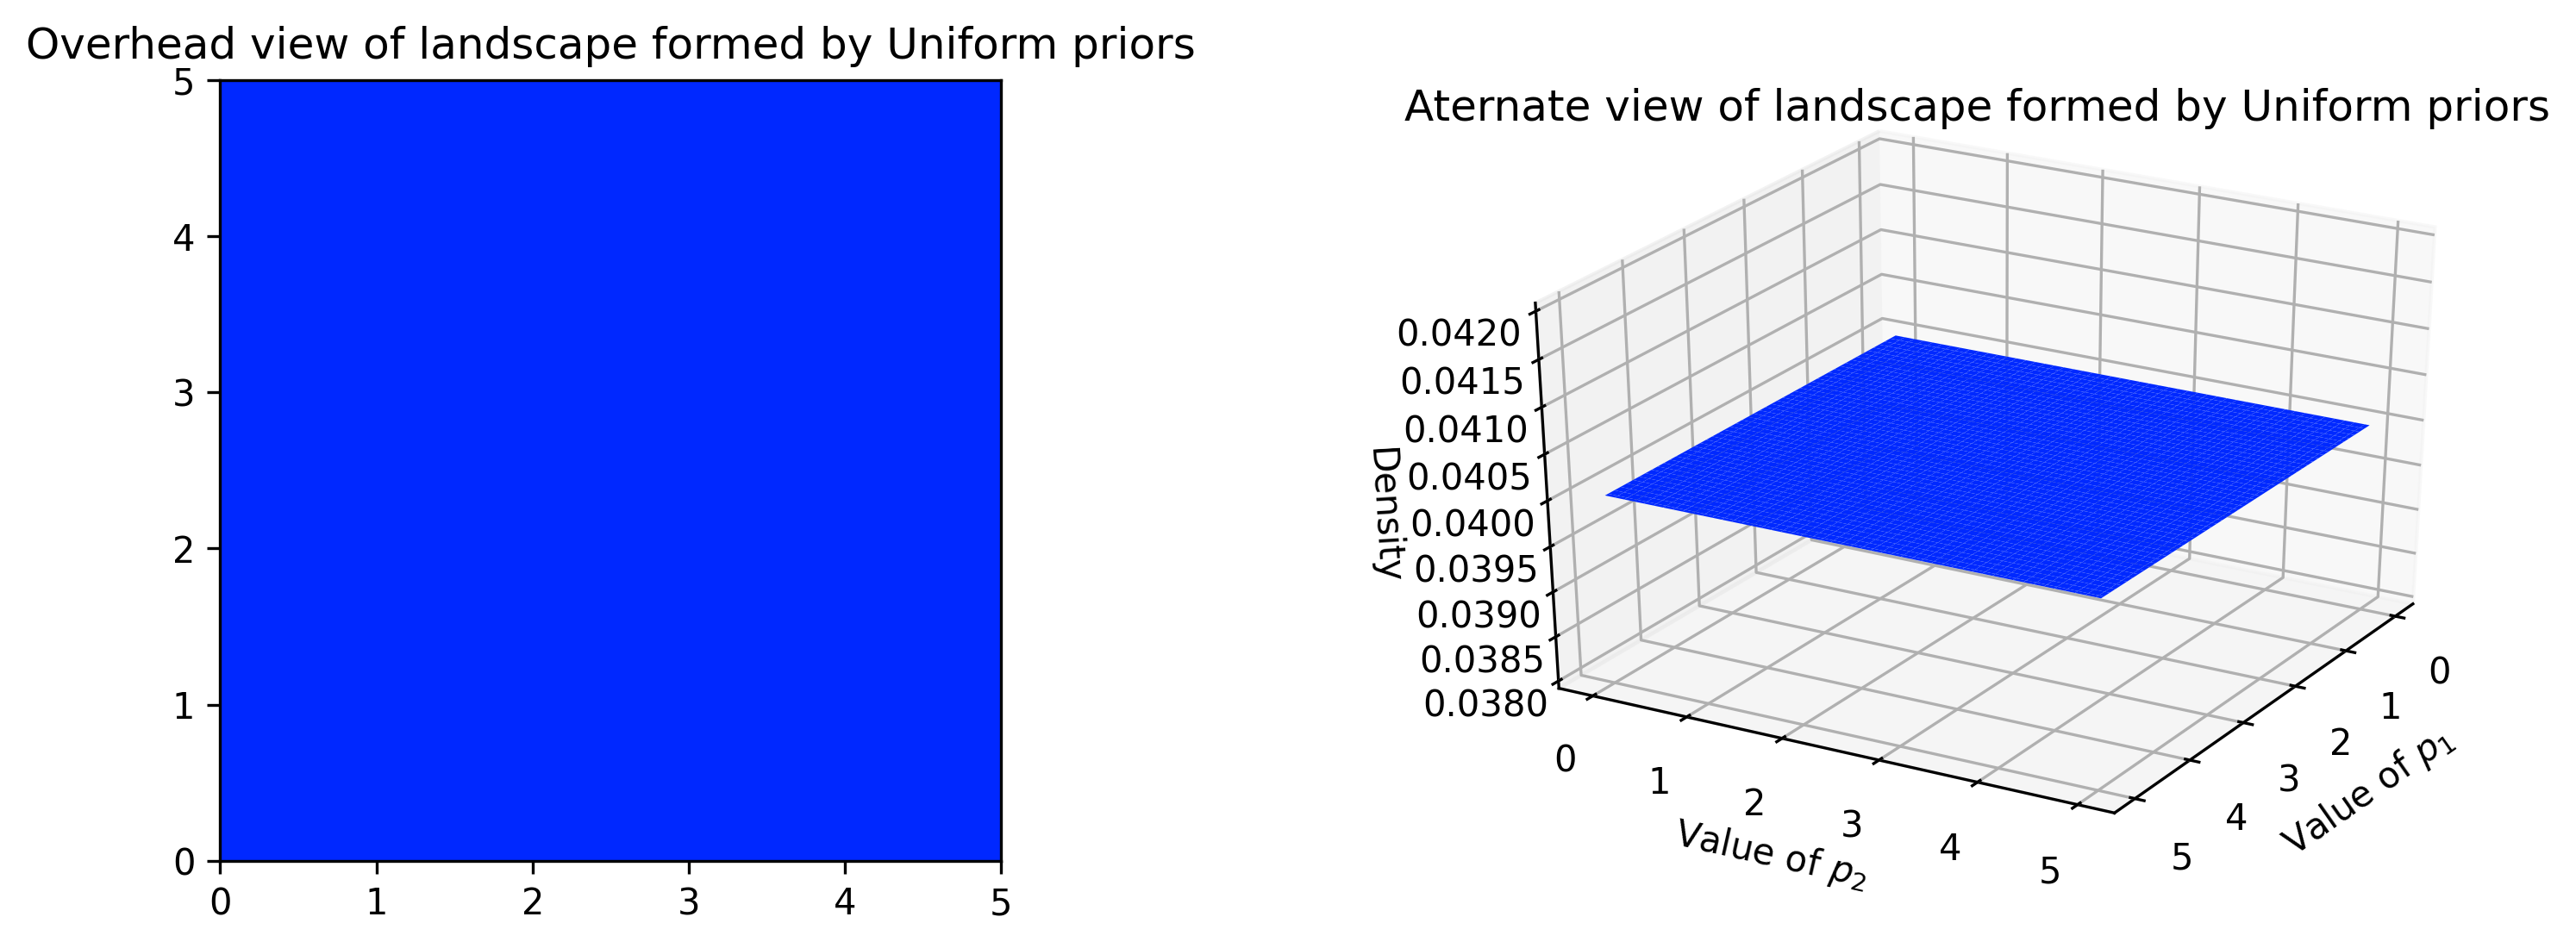

In [3]:
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

jet = plt.cm.jet

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

fig = plt.figure()
plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-0.15
                , extent=(0,5,0,5))
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Overhead view of landscape formed by Uniform priors')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('Value of $p_1$')
ax.set_ylabel('Value of $p_2$')
ax.set_zlabel('Density')
plt.title('Aternate view of landscape formed by Uniform priors');

If two priors are changed to $Exp(3)$ and $Exp(10)$:

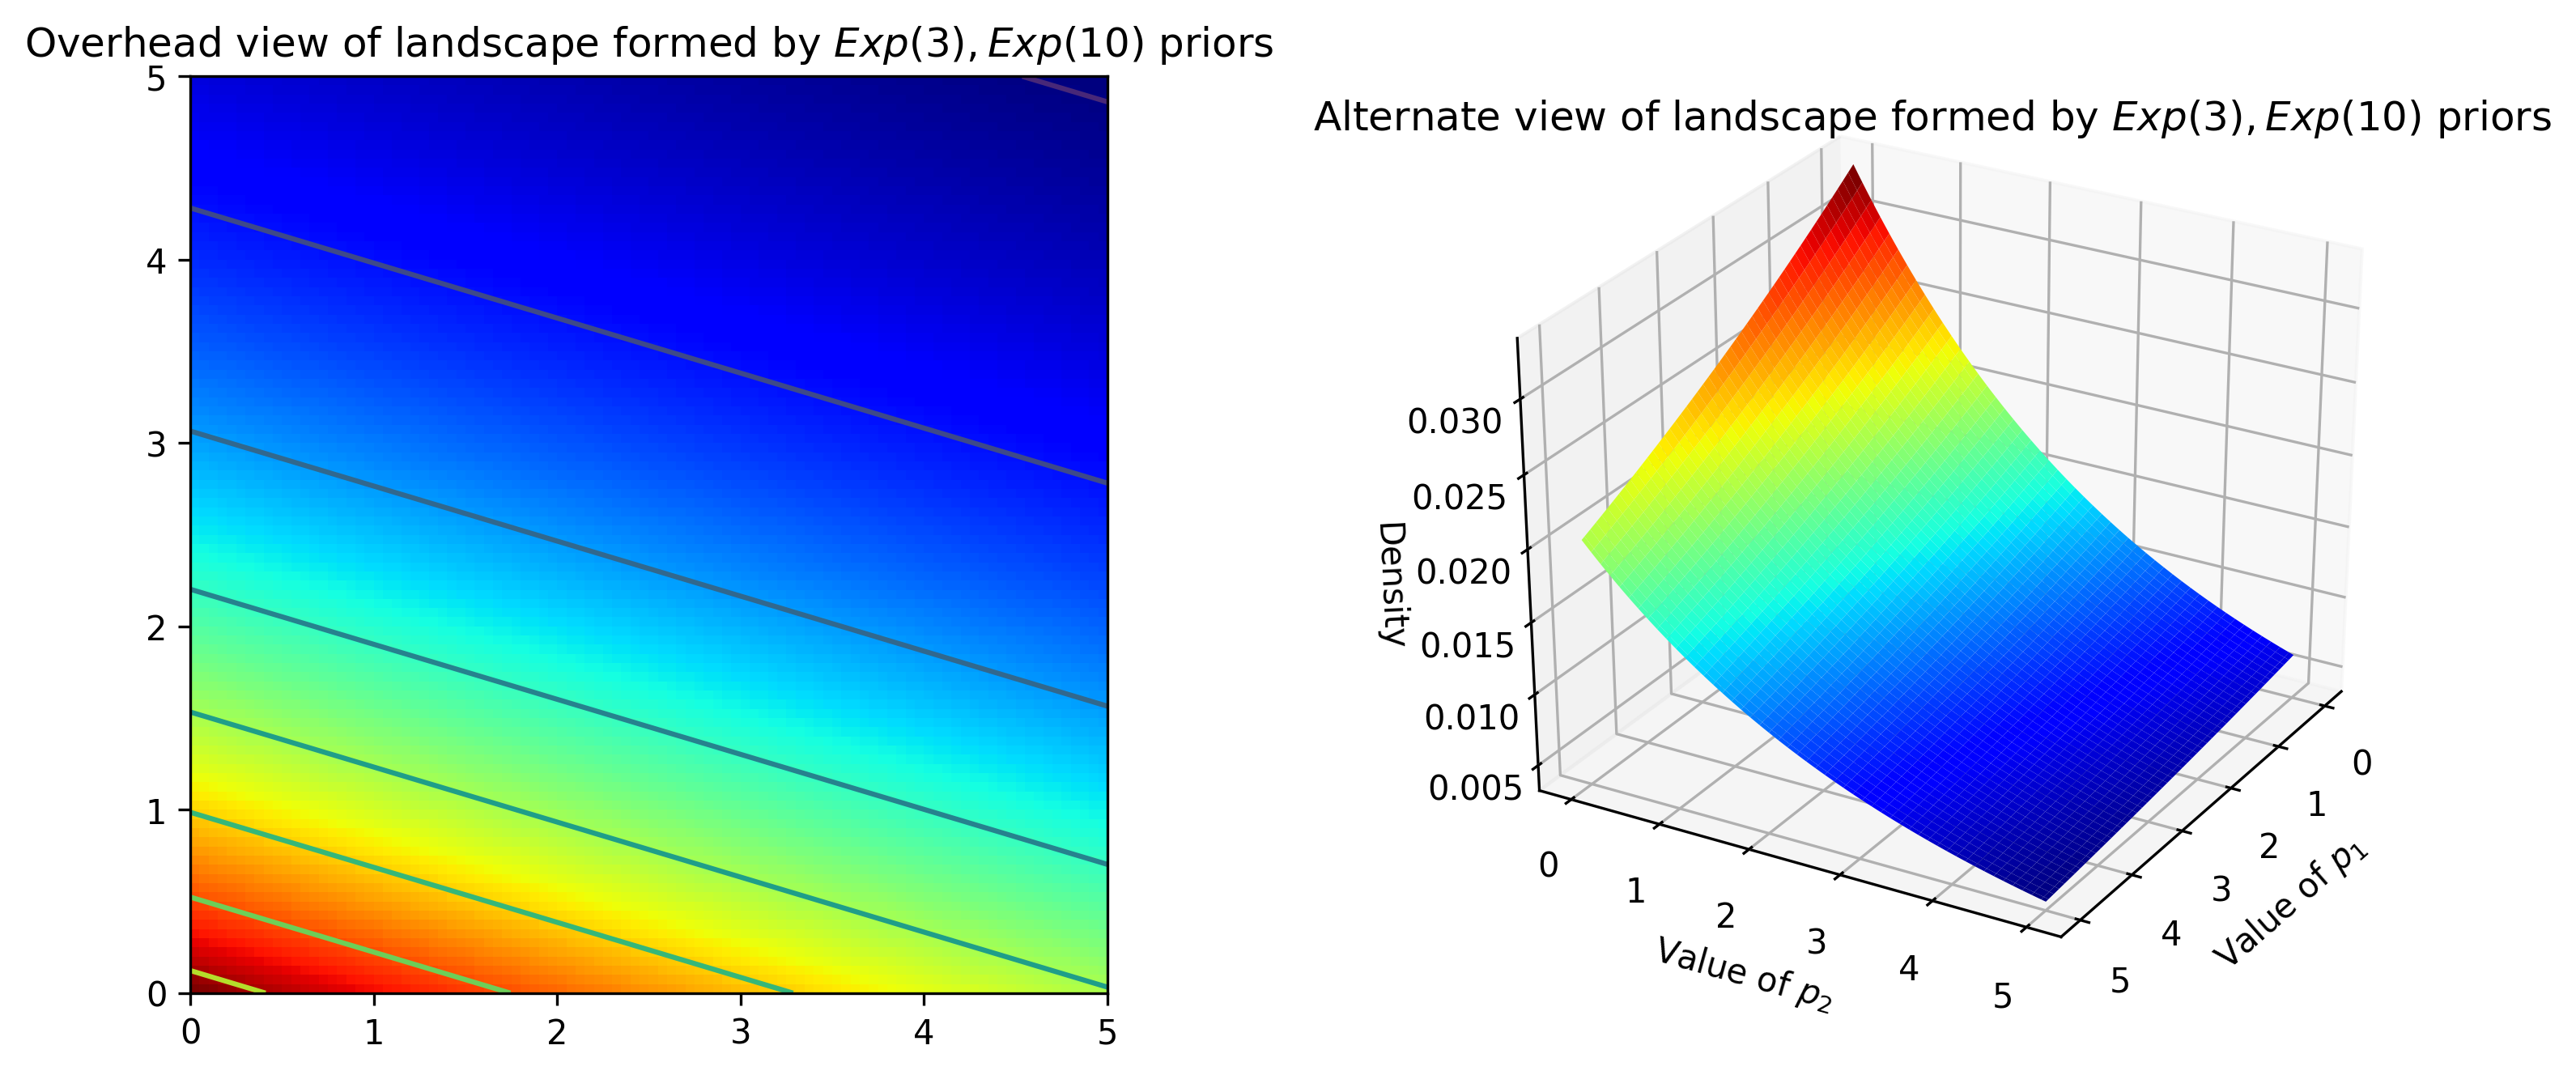

In [4]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(y, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0,5,0,5))
plt.title('Overhead view of landscape formed by $Exp(3), Exp(10)$ priors')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel('Value of $p_1$')
ax.set_ylabel('Value of $p_2$')
ax.set_zlabel('Density')
plt.title('Alternate view of landscape formed by $Exp(3), Exp(10)$ priors');

These surfaces describe the *prior distributions* on the unknowns. After incorporated with the observed data $X$, the data $X$ does not change the space, but changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. The resulting surface describes the new *posterior distributions*.

Suppose two Poisson distributions are performed for inference, each with an unknown $\lambda$ parameter. Compare a Uniform prior and an Exponential prior for the $\lambda$ unknowns. Assume there is an observed data point.

In [5]:
## Create the observed data

# sample size of data
N = 1

# the true parameters, not known
lambda_1_true = 1
lambda_2_true = 3

# generate data dependent on the preceding two values
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print('Observed (2-dimensional, sample size = {}): {}'.format(N, data))

Observed (2-dimensional, sample size = 1): [[0 3]]


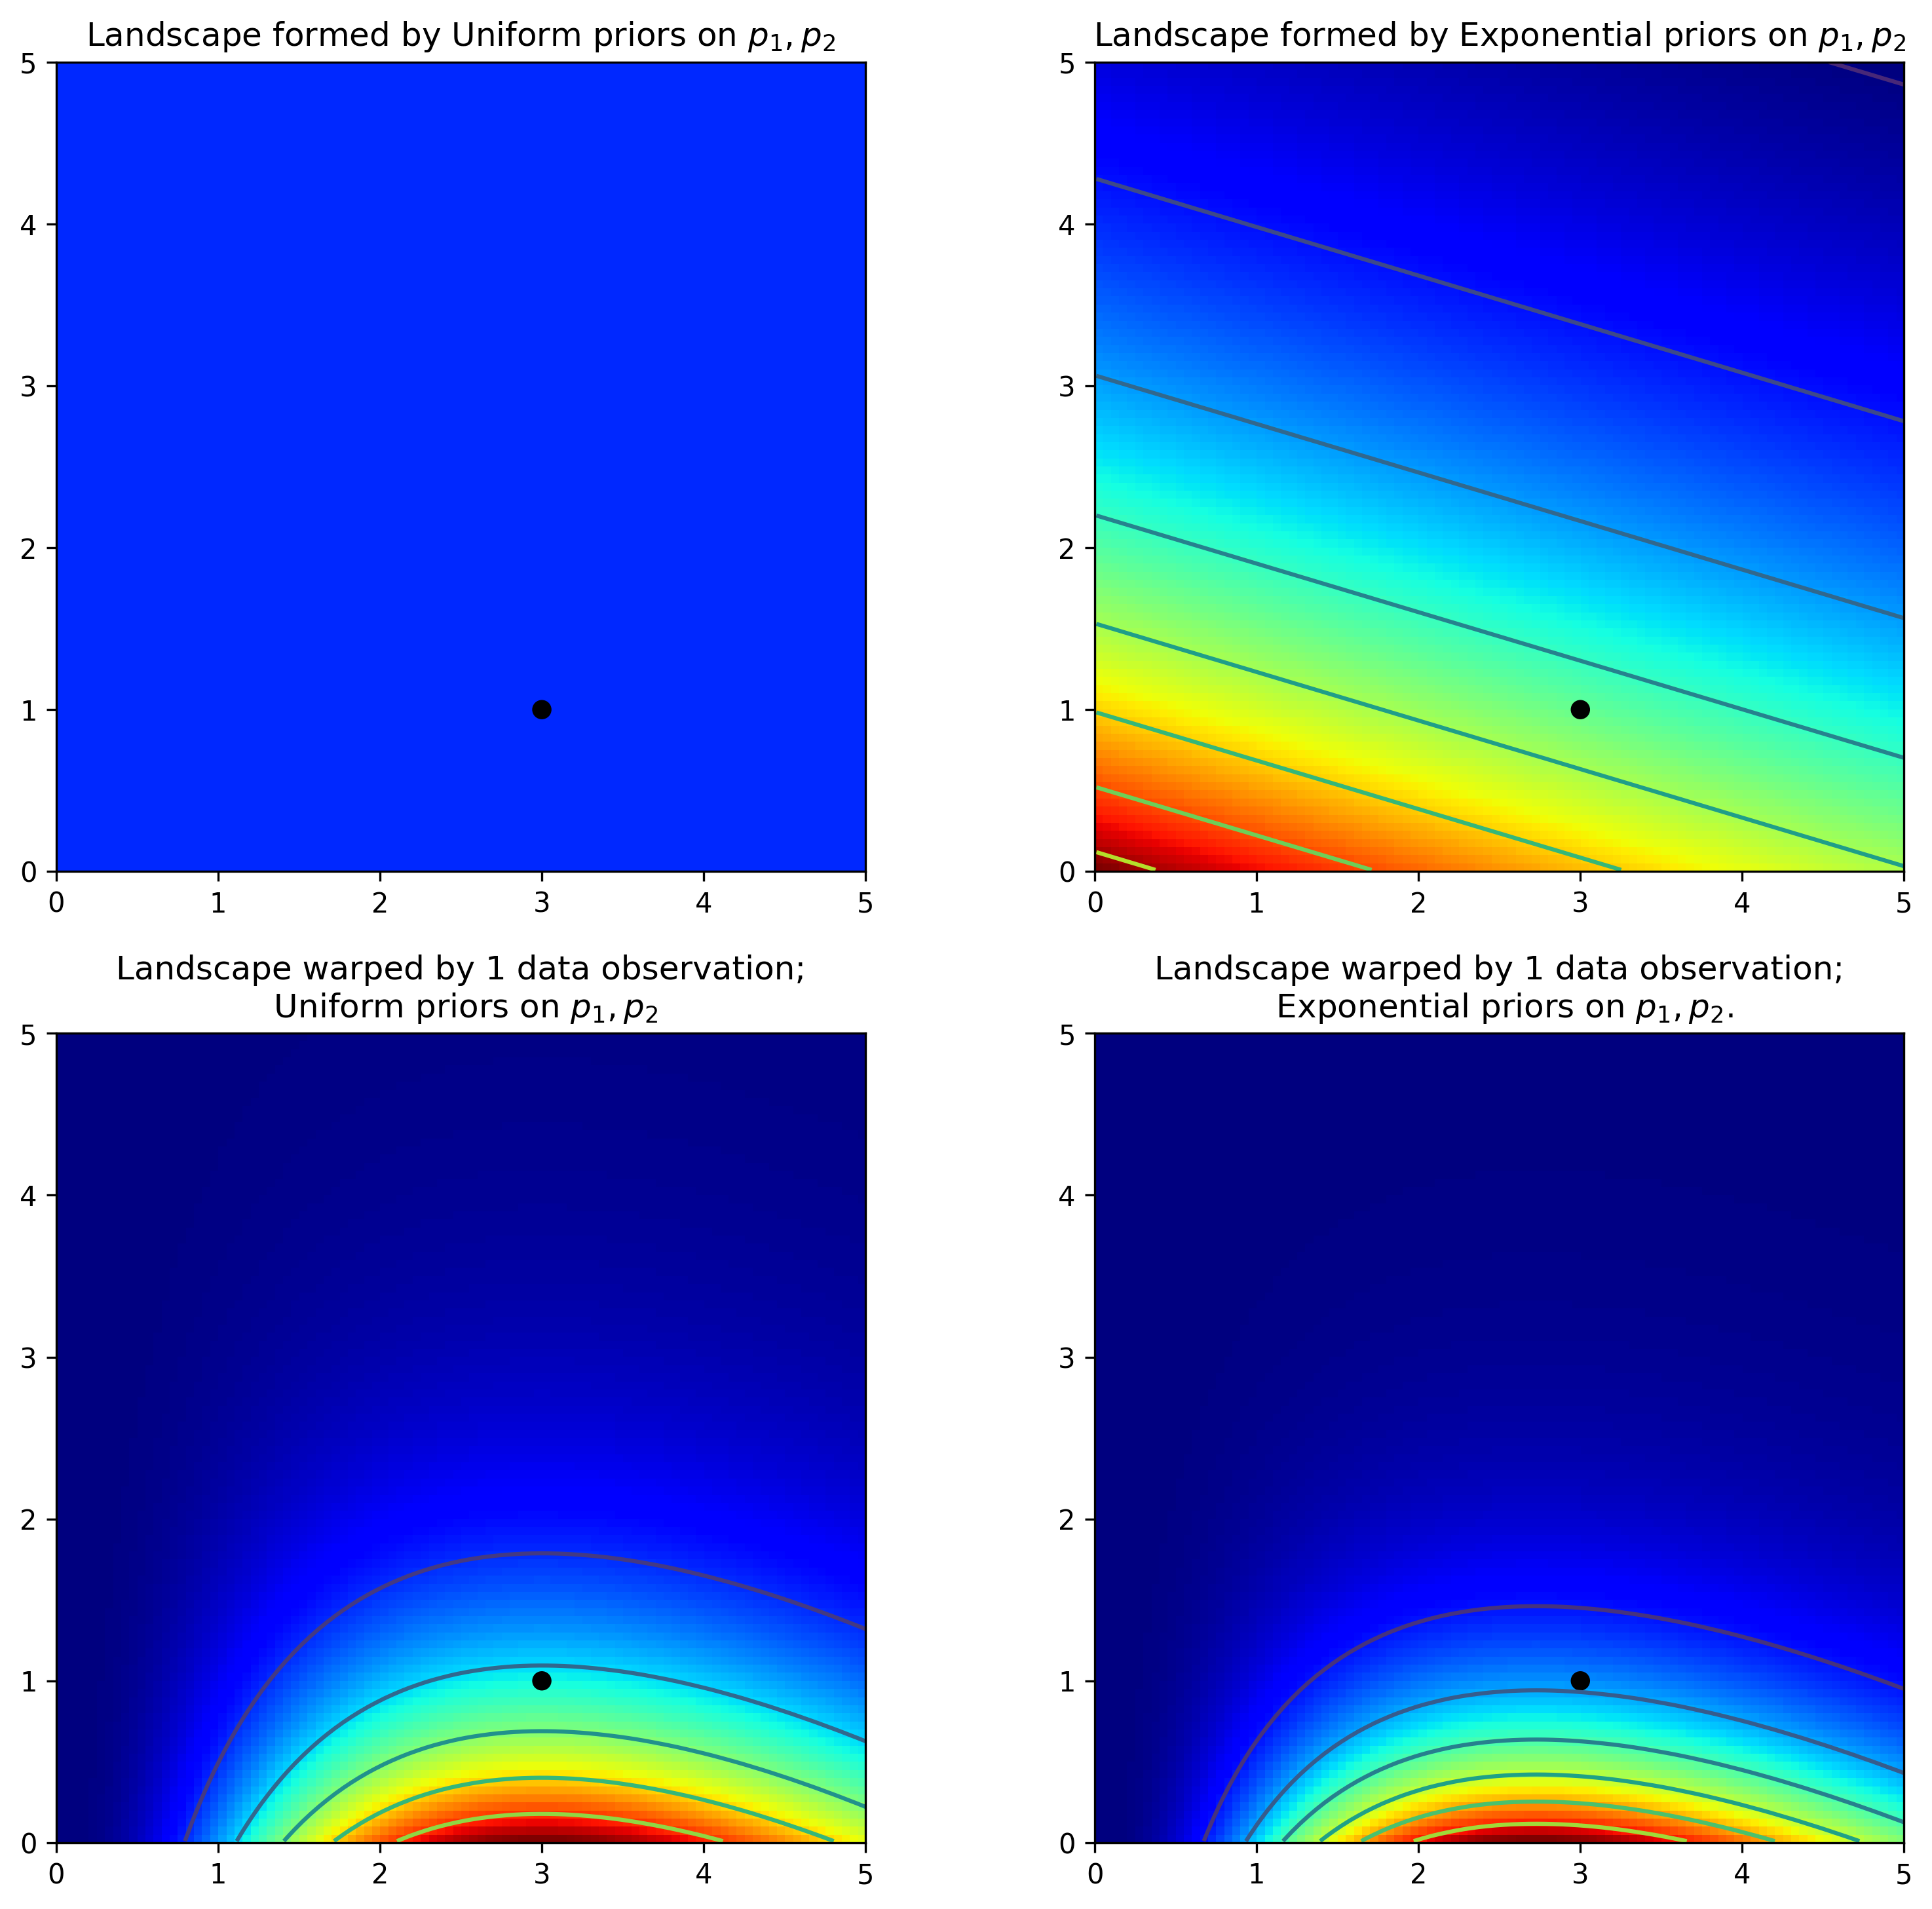

In [6]:
# plotting details
x = y = np.linspace(0.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

figsize(12.5, 12)

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0,5,0,5))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50,
            edgecolor='none')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Landscape formed by Uniform priors on $p_1, p_2$')

plt.subplot(223)
plt.contour(x, y, M*L)
im = plt.imshow(M*L, interpolation='none', origin='lower',
                cmap=jet, extent=(0,5,0,5))
plt.title('Landscape warped by {} data observation;\n Uniform priors on $p_1, p_2$'.format(N))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50, edgecolors='none')
plt.xlim(0,5)
plt.ylim(0,5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0,5,0,5))
plt.scatter(lambda_2_true, lambda_1_true, c='k', s=50,
            edgecolor='none')
plt.xlim(0,5)
plt.ylim(0,5)
plt.title('Landscape formed by Exponential priors on $p_1, p_2$')

plt.subplot(224)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by {} data observation;\n Exponential priors on $p_1, p_2$.".format(N))
plt.xlim(0, 5)
plt.ylim(0, 5);

The black dot in each of the four panels represents the true parameters. The bottom two panels represent the posteriors.

The idea behind MCMC is to perform an intelligent search of the space.

MCMC returns *samples* from the posterior distribution, not the distribution itself. In MCMC and PyMC lingo, the samples in the posterior distribution called the **traces**.

With the thousands of samples, the posterior surface can be reconstructed by organizing them in a histogram.

###Algorithms to Perform MCMC
1. Start at the current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain)
4. (a) If you accept: Move to the new position. Return to Step 1. (b) Else: Do not move to the new position. Return to Step 1.
5. After a large number of iterations, return all accepted positions.

###Example: Unsupervised Clustering Using a Mixture Model

In [7]:
data = np.array([1.158567914166645352e+02,
        1.522615371577288670e+02,
        1.788744905891352914e+02,
        1.629350081470792588e+02,
        1.070282069704478687e+02,
        1.051914114638578326e+02,
        1.183828850125410668e+02,
        1.253769803023669596e+02,
        1.028805401104259118e+02,
        2.067132613581522378e+02,
        1.393689112736414870e+02,
        1.554104808778958500e+02,
        1.487593071755844676e+02,
        8.375957653422238991e+01,
        1.399077526119093307e+02,
        1.206223893711136839e+02,
        1.355653294182054935e+02,
        1.048872555335645700e+02,
        1.100078889548582310e+02,
        1.188513733603652440e+02,
        1.132073362373470928e+02,
        1.014642371115838984e+02,
        5.356401814042712317e+01,
        8.343273493925009632e+01,
        1.583050349068367382e+02,
        1.064199800668446869e+02,
        1.558244033676002402e+02,
        1.131988392873396521e+02,
        1.267707052969062715e+02,
        1.373788302432297712e+02,
        1.206953931925136061e+02,
        1.115746362929019284e+02,
        1.154467698745591520e+02,
        9.923198975585711423e+01,
        1.316472257470074680e+02,
        9.996377019794388730e+01,
        1.114213874064032979e+02,
        1.246905912527673479e+02,
        1.391450928299441898e+02,
        1.361514286100230322e+02,
        1.307114960428298787e+02,
        8.081320412094767391e+01,
        1.078213581175719611e+02,
        1.262596451507411501e+02,
        1.712742662463147383e+02,
        1.570100443945581219e+02,
        8.570544719055581595e+01,
        1.135717929149446377e+02,
        1.370765432994399475e+02,
        7.990858139039664820e+01,
        4.740688606684956596e+01,
        6.701135245547557417e+01,
        1.316212901516728664e+02,
        1.327180223388547233e+02,
        1.685093629801724546e+02,
        1.337698992870340646e+02,
        1.755485831680152558e+02,
        1.655242363776454511e+02,
        1.268471820873596698e+02,
        1.676015711703536226e+02,
        1.455898511751295246e+02,
        1.956160184192707447e+02,
        1.182224625628614518e+02,
        8.925085983612626706e+01,
        1.286269237190567196e+02,
        9.946176931548411915e+01,
        1.571061188364705856e+02,
        1.002501134175815167e+02,
        1.178736425808296389e+02,
        9.422954036020570356e+01,
        9.632336367696697721e+01,
        1.309771108808969871e+02,
        1.181391667258337890e+02,
        8.718473890259349446e+01,
        1.467363729533580283e+02,
        1.257994960590099538e+02,
        1.034723269322880412e+02,
        1.117477319618722476e+02,
        1.346570263925455890e+02,
        1.104112268972690600e+02,
        1.240279649415264771e+02,
        9.058614097837573809e+01,
        1.743529241470696718e+02,
        1.454735444682585239e+02,
        1.200774356852196547e+02,
        7.684825811735771595e+01,
        1.327615627530778681e+02,
        9.236097068799219301e+01,
        9.552784968289883238e+01,
        1.332776882106832943e+02,
        1.473534846560240510e+02,
        1.020106291189790824e+02,
        9.650714482034651098e+01,
        7.139916441047688522e+01,
        1.401992316904928657e+02,
        9.516569029497389920e+01,
        1.419834249663591095e+02,
        1.066032295735071500e+02,
        1.502077702798387122e+02,
        1.708914207381996277e+02,
        1.299656738905514715e+02,
        1.135507706312860989e+02,
        1.853554068292964416e+02,
        9.021956920397798285e+01,
        6.968136186221670414e+01,
        9.037055157785742665e+01,
        1.332929122157154040e+02,
        1.438895971894569925e+02,
        1.999686126528019372e+02,
        7.347125660893672716e+01,
        1.724387017675225593e+02,
        1.739221981887874904e+02,
        1.604682597323718483e+02,
        5.568169798182179875e+01,
        1.585200286677854251e+02,
        1.040052091982859821e+02,
        1.063286334389799492e+02,
        1.626048095277152470e+02,
        7.911796631966825544e+01,
        1.307427048577662561e+02,
        2.057499230950611206e+02,
        1.968272359917557139e+02,
        1.881442820837430077e+02,
        2.099549294015370151e+02,
        1.998661946532027969e+02,
        2.118440756588201168e+02,
        1.606377918214757301e+02,
        2.345495227313272721e+02,
        1.979870202889300117e+02,
        1.767565653027037627e+02,
        2.392032562427630751e+02,
        2.203634866605279967e+02,
        2.186204436985496784e+02,
        1.958292604060661688e+02,
        1.763536231210040341e+02,
        1.720099990072054084e+02,
        2.276111145823536503e+02,
        2.031618190973077560e+02,
        2.203394620375324564e+02,
        1.748951748467622167e+02,
        2.246467115445838658e+02,
        2.063262381110193644e+02,
        2.243575662535018296e+02,
        1.784441729981658966e+02,
        2.062286003797039768e+02,
        1.775707944495688935e+02,
        2.155143763250597715e+02,
        1.773479541349278747e+02,
        1.812393484934563048e+02,
        2.016410664104029422e+02,
        1.457178963053429754e+02,
        1.811158727168051996e+02,
        1.698815048205628386e+02,
        1.980526657461653031e+02,
        2.237926507603949631e+02,
        2.041601282859148228e+02,
        2.190976423331983938e+02,
        1.549803951612012156e+02,
        2.287320184948024178e+02,
        1.795089638168848865e+02,
        2.147749276781472645e+02,
        1.929292605280932094e+02,
        1.978032695208104599e+02,
        1.952622325493282176e+02,
        1.947411074628796541e+02,
        1.912293268737790584e+02,
        2.003683540126394291e+02,
        2.237343543228302565e+02,
        2.167961900446733807e+02,
        2.037151496864689761e+02,
        1.893550986737426172e+02,
        1.869543411645419724e+02,
        1.835808441751185001e+02,
        1.970709582802755335e+02,
        1.839483199132450295e+02,
        1.897348523707564141e+02,
        2.070561460762054935e+02,
        1.895452441676222008e+02,
        1.988034028044728245e+02,
        2.222104995656967219e+02,
        1.982884182490368516e+02,
        2.301793802104767792e+02,
        2.083751959215908585e+02,
        2.072072807011673206e+02,
        2.117554526928701648e+02,
        2.239912916180006164e+02,
        1.577304662746984150e+02,
        2.029046447898107886e+02,
        2.123748400232716733e+02,
        2.256038299100258939e+02,
        1.604587483000290717e+02,
        2.126142493549542394e+02,
        1.865778321564264672e+02,
        1.878548632982883646e+02,
        1.936829299162293694e+02,
        2.008257869594140175e+02,
        2.114054096588270681e+02,
        2.224942360518713826e+02,
        2.163203170742532109e+02,
        2.196077609078524517e+02,
        1.965973422923452461e+02,
        2.260630069755815157e+02,
        2.175726737014800847e+02,
        1.894721271217474055e+02,
        1.880419412421656489e+02,
        2.055349450451877829e+02,
        2.001211541598505335e+02,
        1.701979823394767095e+02,
        1.814417868513972110e+02,
        2.170818157769599566e+02,
        2.043390449169586986e+02,
        2.142939835438931766e+02,
        2.088157337161389648e+02,
        2.364166235642270237e+02,
        1.758551925587188691e+02,
        2.189818950071079371e+02,
        1.608246952687757698e+02,
        2.173397571355294247e+02,
        2.048043194911894886e+02,
        1.795463132346284851e+02,
        1.848474669873958192e+02,
        2.776035847947849788e+02,
        1.979652195279244609e+02,
        1.751710082689644423e+02,
        1.791648298902669012e+02,
        2.413463278928517184e+02,
        2.109572103136984822e+02,
        2.377593925070711123e+02,
        1.646185402973937641e+02,
        2.017302046842930281e+02,
        2.270142240478414237e+02,
        2.053500422399993681e+02,
        1.781980289145491554e+02,
        1.813298787113023991e+02,
        1.861273376270083304e+02,
        1.948307857093440987e+02,
        2.138709248980183872e+02,
        2.273093834599274317e+02,
        1.937184180374936773e+02,
        1.973234243988711398e+02,
        1.773274744436027390e+02,
        2.331499462797156070e+02,
        1.813647726372266504e+02,
        2.164952973412599704e+02,
        2.068273352048135223e+02,
        1.907417796433622073e+02,
        1.601869449674381372e+02,
        2.359528734619659076e+02,
        2.142796628839945186e+02,
        2.220949791177241082e+02,
        1.986970344800319026e+02,
        1.984994134360097178e+02,
        2.016572983625352435e+02,
        2.045002706098395606e+02,
        2.152174652951992471e+02,
        1.987922144174747530e+02,
        2.241648159527295547e+02,
        2.205483546065124472e+02,
        1.558159484378380171e+02,
        1.676495617850407598e+02,
        1.850186838826528231e+02,
        2.464145786167696599e+02,
        2.486409397084338195e+02,
        1.767515487795867273e+02,
        1.869117804626637849e+02,
        1.870810635558241586e+02,
        1.958352409681716324e+02,
        1.614541679698469920e+02,
        1.820210126509980739e+02,
        2.199473579766136595e+02,
        2.133444798833926654e+02,
        2.090551017466646613e+02,
        2.046156673206388064e+02,
        1.992916910824319530e+02,
        1.946361653458499745e+02,
        2.421374635348616948e+02,
        2.110007927344491918e+02,
        1.662765715442542671e+02,
        1.949143298584492641e+02,
        1.875771759652629953e+02,
        2.219149956242236783e+02,
        1.876747717865994218e+02,
        1.971850332862213122e+02,
        1.482140589550791105e+02,
        2.064803608972869711e+02,
        2.134641290909328859e+02,
        1.919518147378720414e+02,
        1.800465916326361935e+02,
        2.203791380076491464e+02,
        2.223561248500241163e+02,
        2.278082046953573752e+02,
        2.181685881622520640e+02,
        1.863762249820889565e+02,
        1.775192919731025256e+02,
        1.764703438636786075e+02,
        2.315749158793883566e+02,
        2.171688340729648985e+02,
        2.423196685427484454e+02,
        1.963990296752487268e+02,
        2.228190673247157747e+02
])

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136]


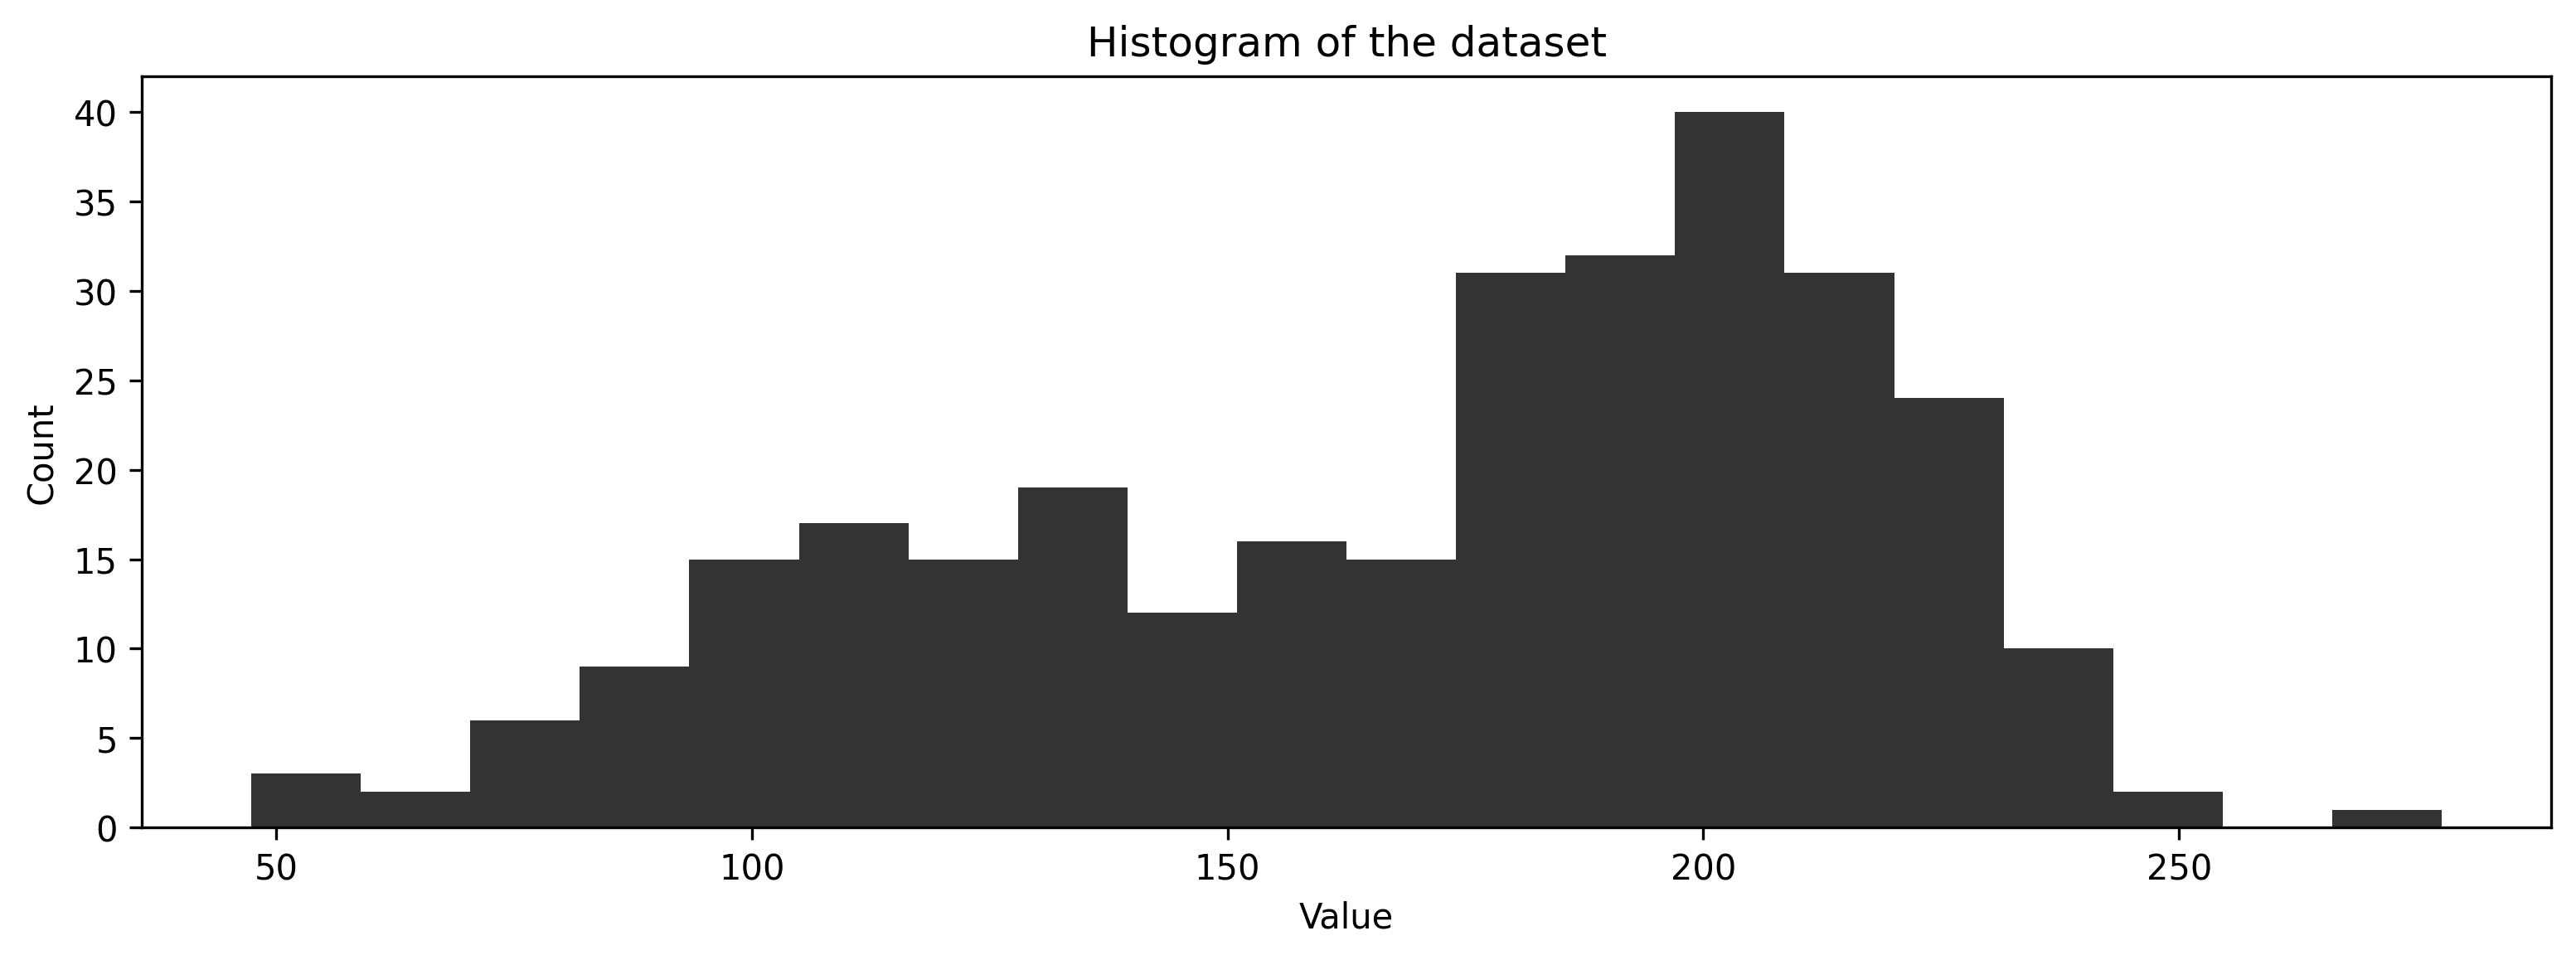

In [8]:
figsize(12.5, 4)
plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.ylim([0, None])
plt.xlabel('Value')
plt.ylabel('Count');
print(data[:10])

From the histogram, it appears to have two peaks. This dataset is a good example of the data-generation modeling technique from Chapter 2.

Thus, two Normal distributions are initialized here. Both have unknown mean and unknown standard deviation. A specific data point can be from either of the Normal distributions.

Assume the data point is assigned to $Nor_0$ with probability $p$. A uniform variable over 0 to 1 is used to model $p$.

An appropriate way to assign data points to clusters is to use a PyMC `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to 1 and its `value` attribute is an integer between 0 to $k-1$ randomly chosen according to the crafted array of probabilities. Thus, the probablities array here in the `Categorical` variable is `[p, 1-p]`.

In [9]:
import pymc as pm

p = pm.Uniform('p', 0., 1.)

assignment = pm.Categorical('assignment', [p, 1-p],
                            size=data.shape[0])
print('Prior assignment, with p = {:.2f}'.format(p.value))
print(assignment.value[:10])

Prior assignment, with p = 0.65
[1 0 0 0 0 1 1 1 0 0]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Without knowing the true standard deviations from two Normal distribution, just initialize them as Uniform on 0 to 100... In the PyMC, remember to convert the *precision*, $\tau$, to the standard deviation, $\sigma$:
$$\tau=\frac{1}{\sigma^2}$$

In [10]:
stds = pm.Uniform('stds', 0, 100, size=2, trace=True)
taus = 1.0 / stds ** 2

Here, both $\tau$s are modeled as a single PyMC variable. This does not induce a necessary relationship between the two $\tau$s.

Next, need to specify priors on the centers of the clusters, which are the means of the Normal distributions. From the histogram above, the guessed means would be $\mu_0=120$ and $\mu_1=190$, with $\sigma_{0,1}=10$ which means $\tau=1/\sigma^2=0.01$ in the PyMC variable.

In [11]:
centers = pm.Normal('centers', [120, 190], [0.01, 0.01], size=2)

The following `deterministic` functions map an assignemnt, in this case 0 or 1, to a set of parameters, located in the (1,2) arrays `taus` and `centers`.

In [12]:
@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

print('Random assignments: {}'.format(assignment.value[:4]) +' ...')
print('Assigned center: {}'.format(center_i.value[:4]) + ' ...')
print('Assigned precision: {}'.format(tau_i.value[:4]) + ' ...')

Random assignments: [1 0 0 0] ...
Assigned center: [186.70650239 123.92066363 123.92066363 123.92066363] ...
Assigned precision: [0.00011092 0.00060074 0.00060074 0.00060074] ...


In [13]:
# Combine it with the observations
observations = pm.Normal('obs', center_i, tau_i, value=data, observed=True)

# Now create a model class
model = pm.Model([p, taus, stds, centers, assignment, observations])

PyMC has an MCMC class, `MCMC` in the main namespace of PyMC:

In [14]:
mcmc = pm.MCMC(model)

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


`pm.sample(iterations)` asks the `MCMC` to explore the space:

In [15]:
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 16.9 sec

To plot the path (or called *traces*) that the unknown parameters (centers, precisions, and *p*) have taken.

The traces can be retrieved using `trace` method in the `MCMC` object. For example, `mcmc.trace('centers')` will retrieve a `Trace` object that can be indexed (using `[:]` or `.gettrace()` to retrieve all traces, or facy-indexing like `[1000:]`)

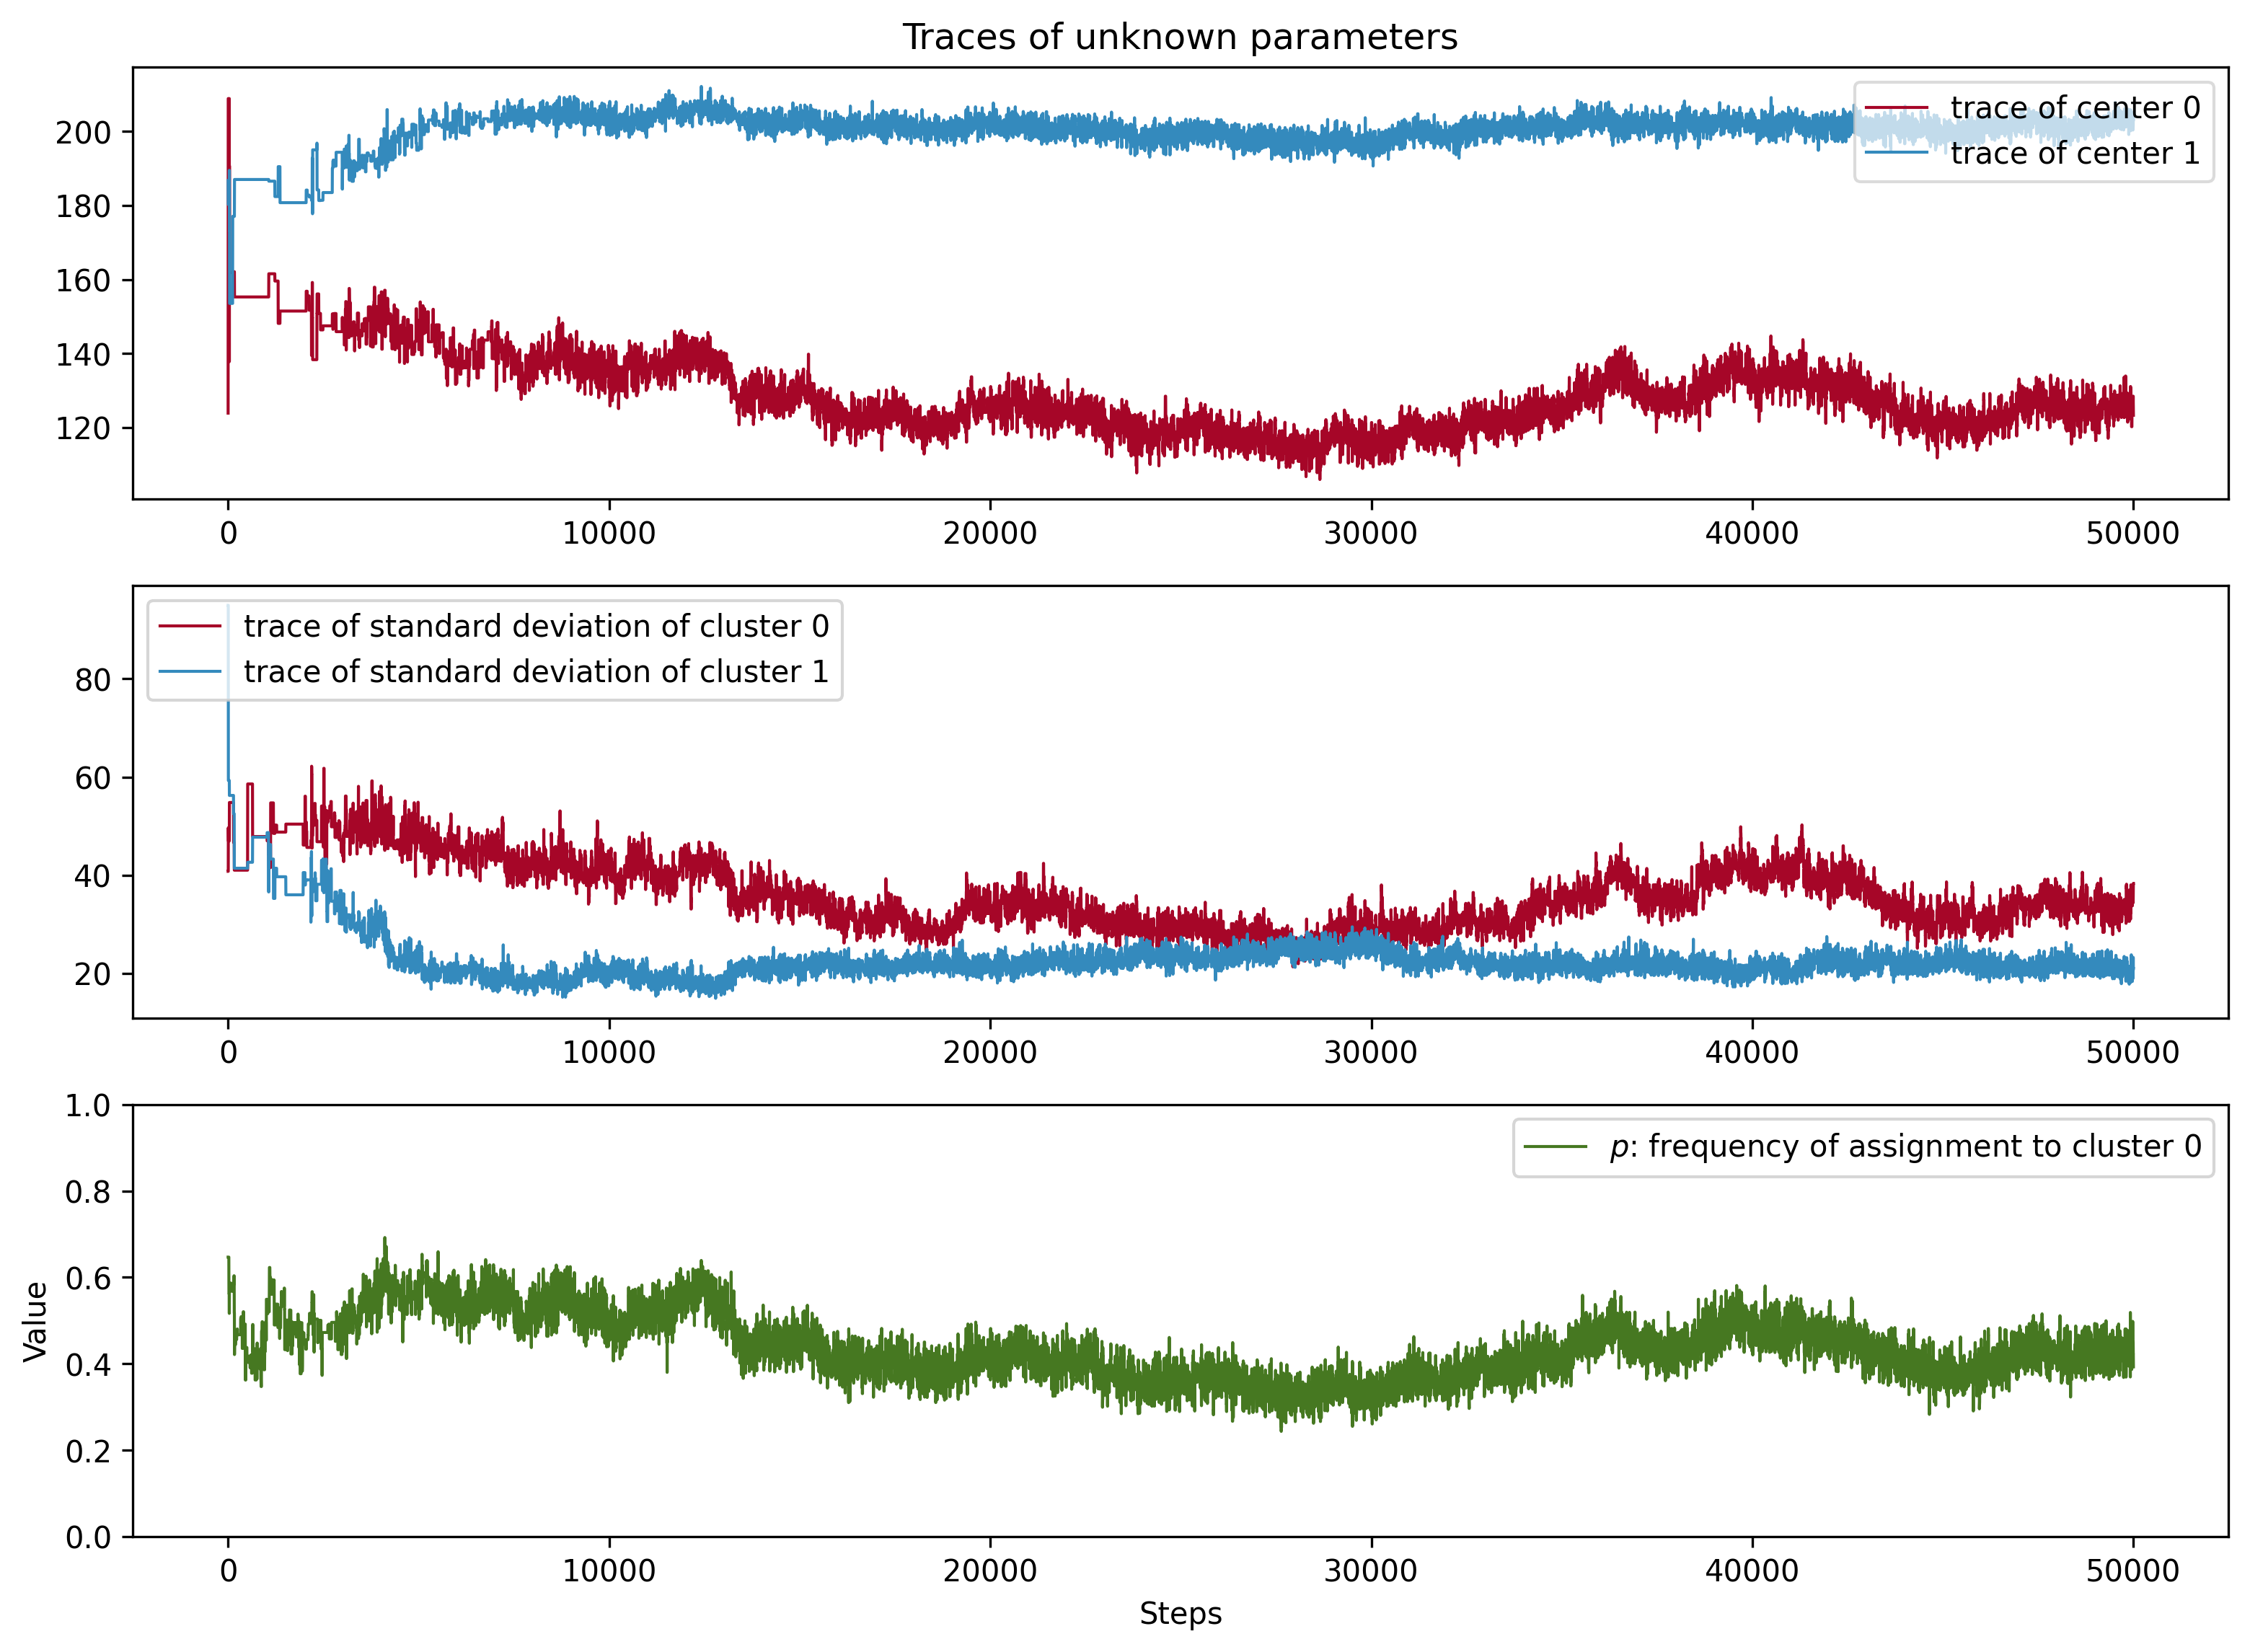

In [17]:
figsize(12.5, 9)
colors = ['#348ABD', '#A60628']
center_trace = mcmc.trace('centers')[:]
if center_trace[-1, 0] < center_trace[-1, 1]:
    colors = ['#A60628', '#348ABD']
line_width = 1

plt.subplot(311)
plt.plot(center_trace[:, 0], label='trace of center 0',
         c=colors[0], lw=line_width)
plt.plot(center_trace[:, 1], label='trace of center 1',
         c=colors[1], lw=line_width)
plt.title('Traces of unknown parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace('stds')[:]
plt.plot(std_trace[:, 0], label='trace of standard deviation of cluster 0', 
         c=colors[0], lw=line_width)
plt.plot(std_trace[:, 1], label='trace of standard deviation of cluster 1', 
         c=colors[1], lw=line_width)
plt.legend(loc='upper left')

plt.subplot(313)
p_trace = mcmc.trace('p')[:]
plt.plot(p_trace, label='$p$: frequency of assignment to cluster 0', color='#467821', lw=line_width)
plt.xlabel('Steps')
plt.ylim(0, 1)
plt.ylabel('Value')
plt.legend();

1. The traces converge to a *distribution* of possible points. This is *convergence* in an MCMC algorithm.
2. The period before converge is called the *burn-in period*.
3. The traces appear as a random walk around the space.

To achieve further convergence, need to perform more MCMC steps. Starting the MCMC again after it has already been called does not mean starting the entire search over.

In [18]:
mcmc.sample(100000)

 [-----------------100%-----------------] 100000 of 100000 complete in 33.9 sec

In [19]:
center_trace = mcmc.trace('centers', chain=1)[:]
prev_center_trace = mcmc.trace('centers', chain=0)[:]

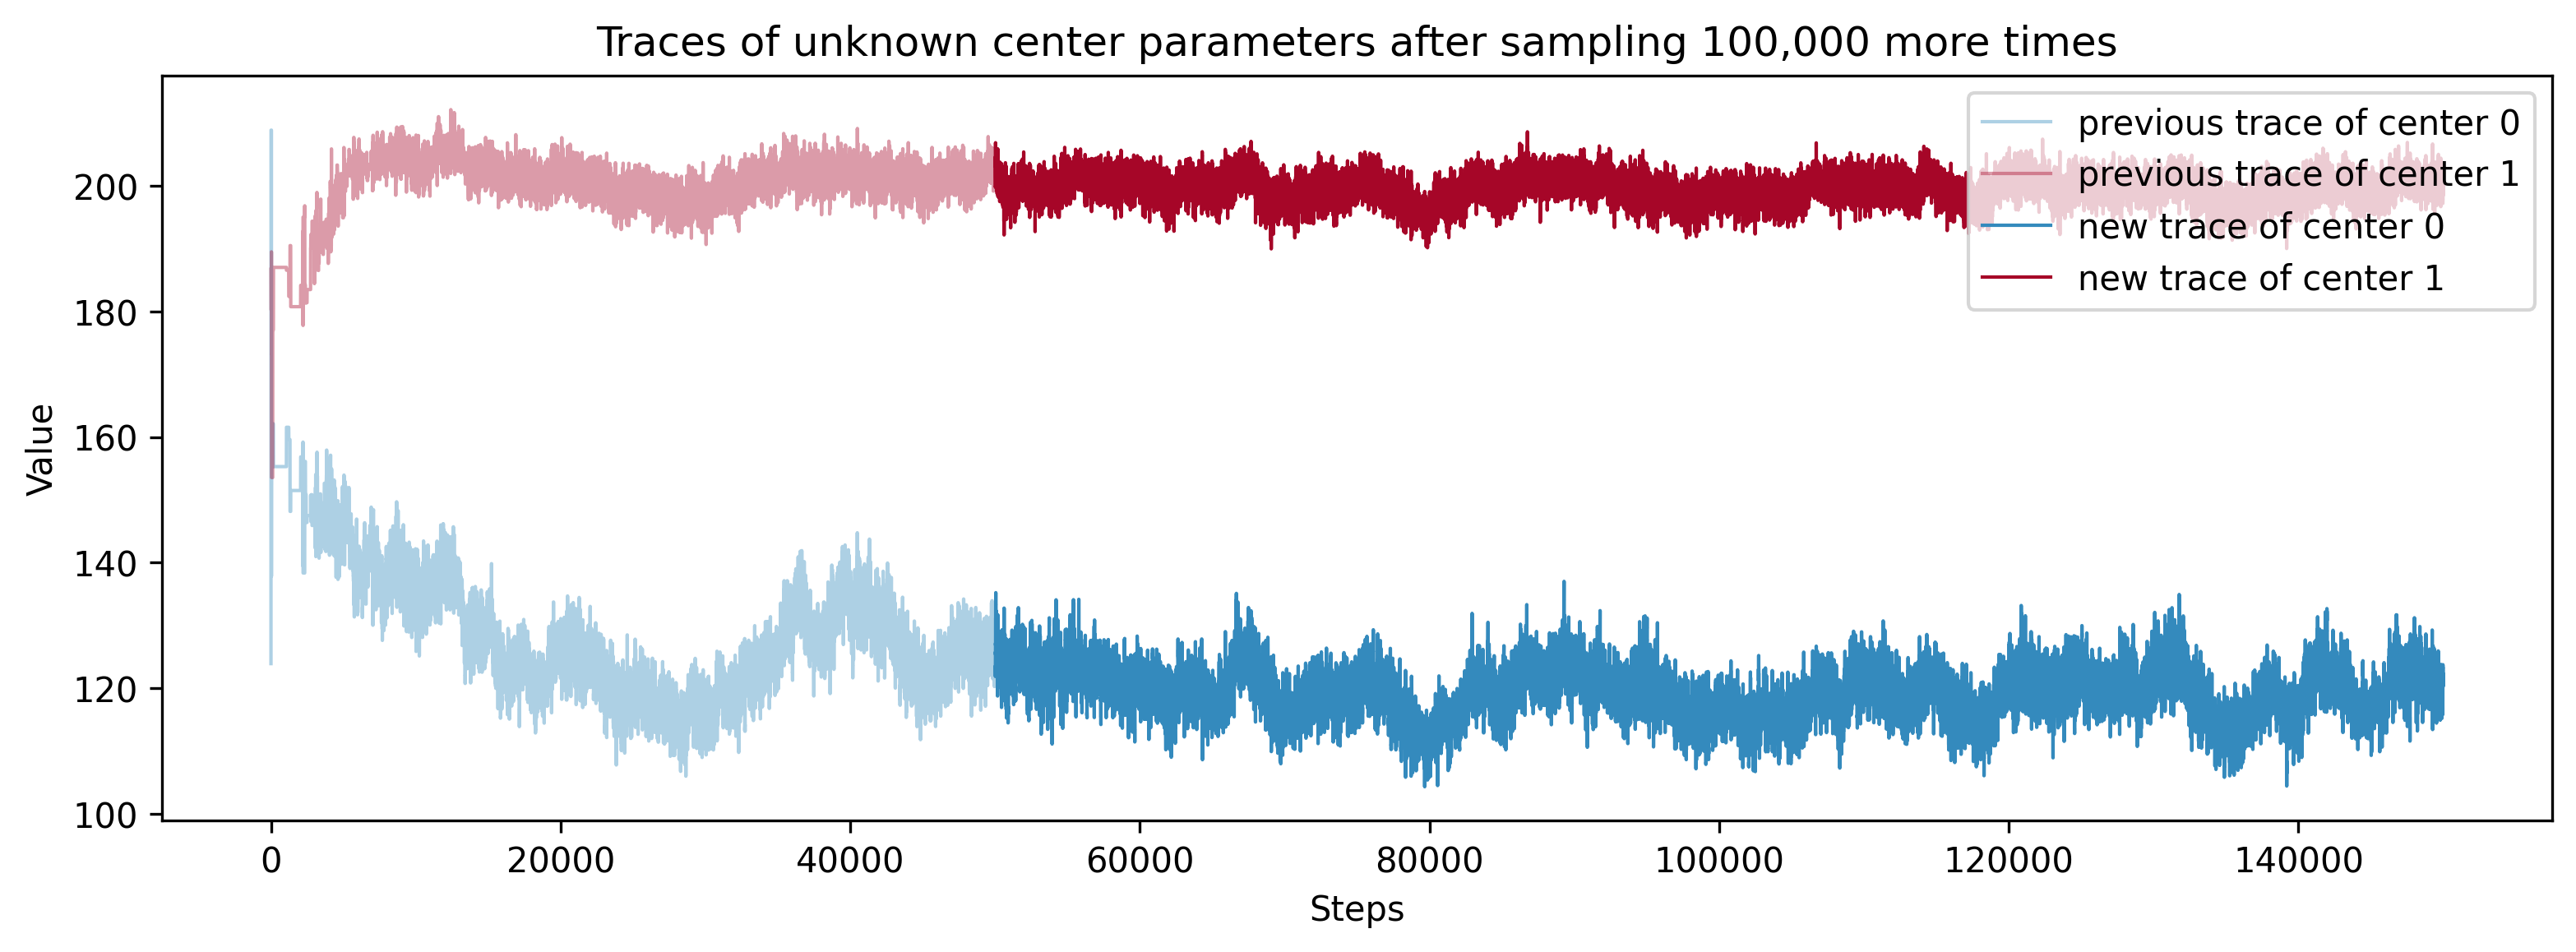

In [20]:
figsize(12.5, 4)
x = np.arange(50000)
plt.plot(x, prev_center_trace[:,0], label='previous trace of center 0',
         lw=line_width, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:,1], label='previous trace of center 1',
         lw=line_width, alpha=0.4, c=colors[0])

x = np.arange(50000, 150000)
plt.plot(x, center_trace[:,0], label='new trace of center 0',
         lw=line_width, c=colors[1])
plt.plot(x, center_trace[:,1], label='new trace of center 1',
         lw=line_width, c=colors[0])
plt.title('Traces of unknown center parameters after sampling 100,000 more times')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.8)
plt.ylabel('Value')
plt.xlabel('Steps');

The `chain` keyword argument in the `trace` method indexes which call to `sample` to be returned.

The posterior distributions for unknowns are determined now. The code below plots the posterior distributions of the center and standard deviation variables:

In [21]:
std_trace = mcmc.trace('stds')[:]

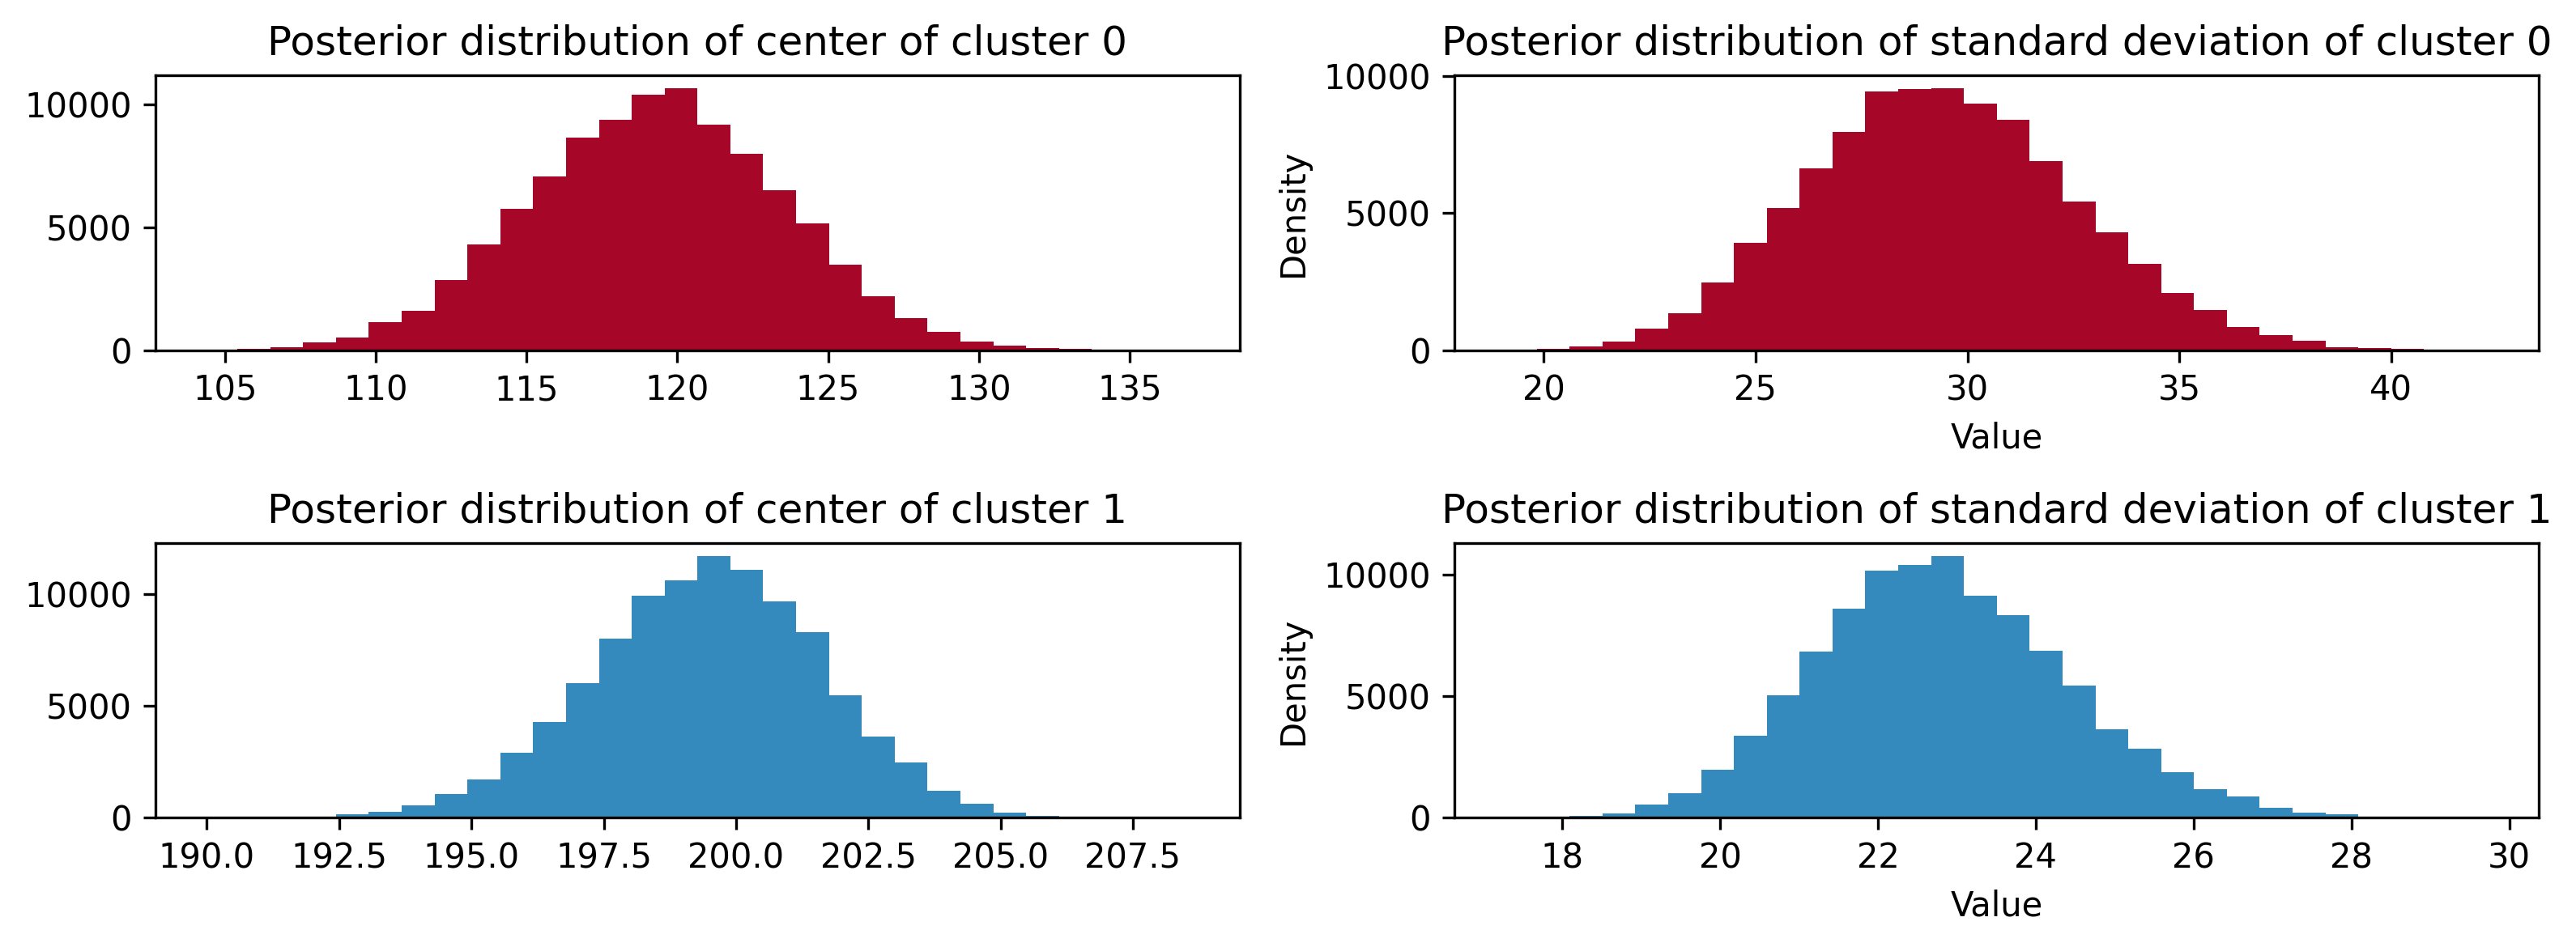

In [22]:
figsize(11, 4)
_i = [1,2,3,4]
for i in range(2):
    plt.subplot(2,2, _i[2*i])
    plt.title('Posterior distribution of center of cluster {}'.format(i))
    plt.hist(center_trace[:,i], color=colors[i], bins=30,
             histtype='stepfilled')
    
    plt.subplot(2,2, _i[2*i +1])
    plt.title('Posterior distribution of standard deviation of cluster {}'.format(i))
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype='stepfilled')
    plt.ylabel('Density')
    plt.xlabel('Value')

plt.tight_layout();

The MCMC algorithm proposed that the most likely centers of the two clusters are near 120 and 202.

The posterior distributions for the labels of the data points is present in `mcmc.trace('assignment')`:

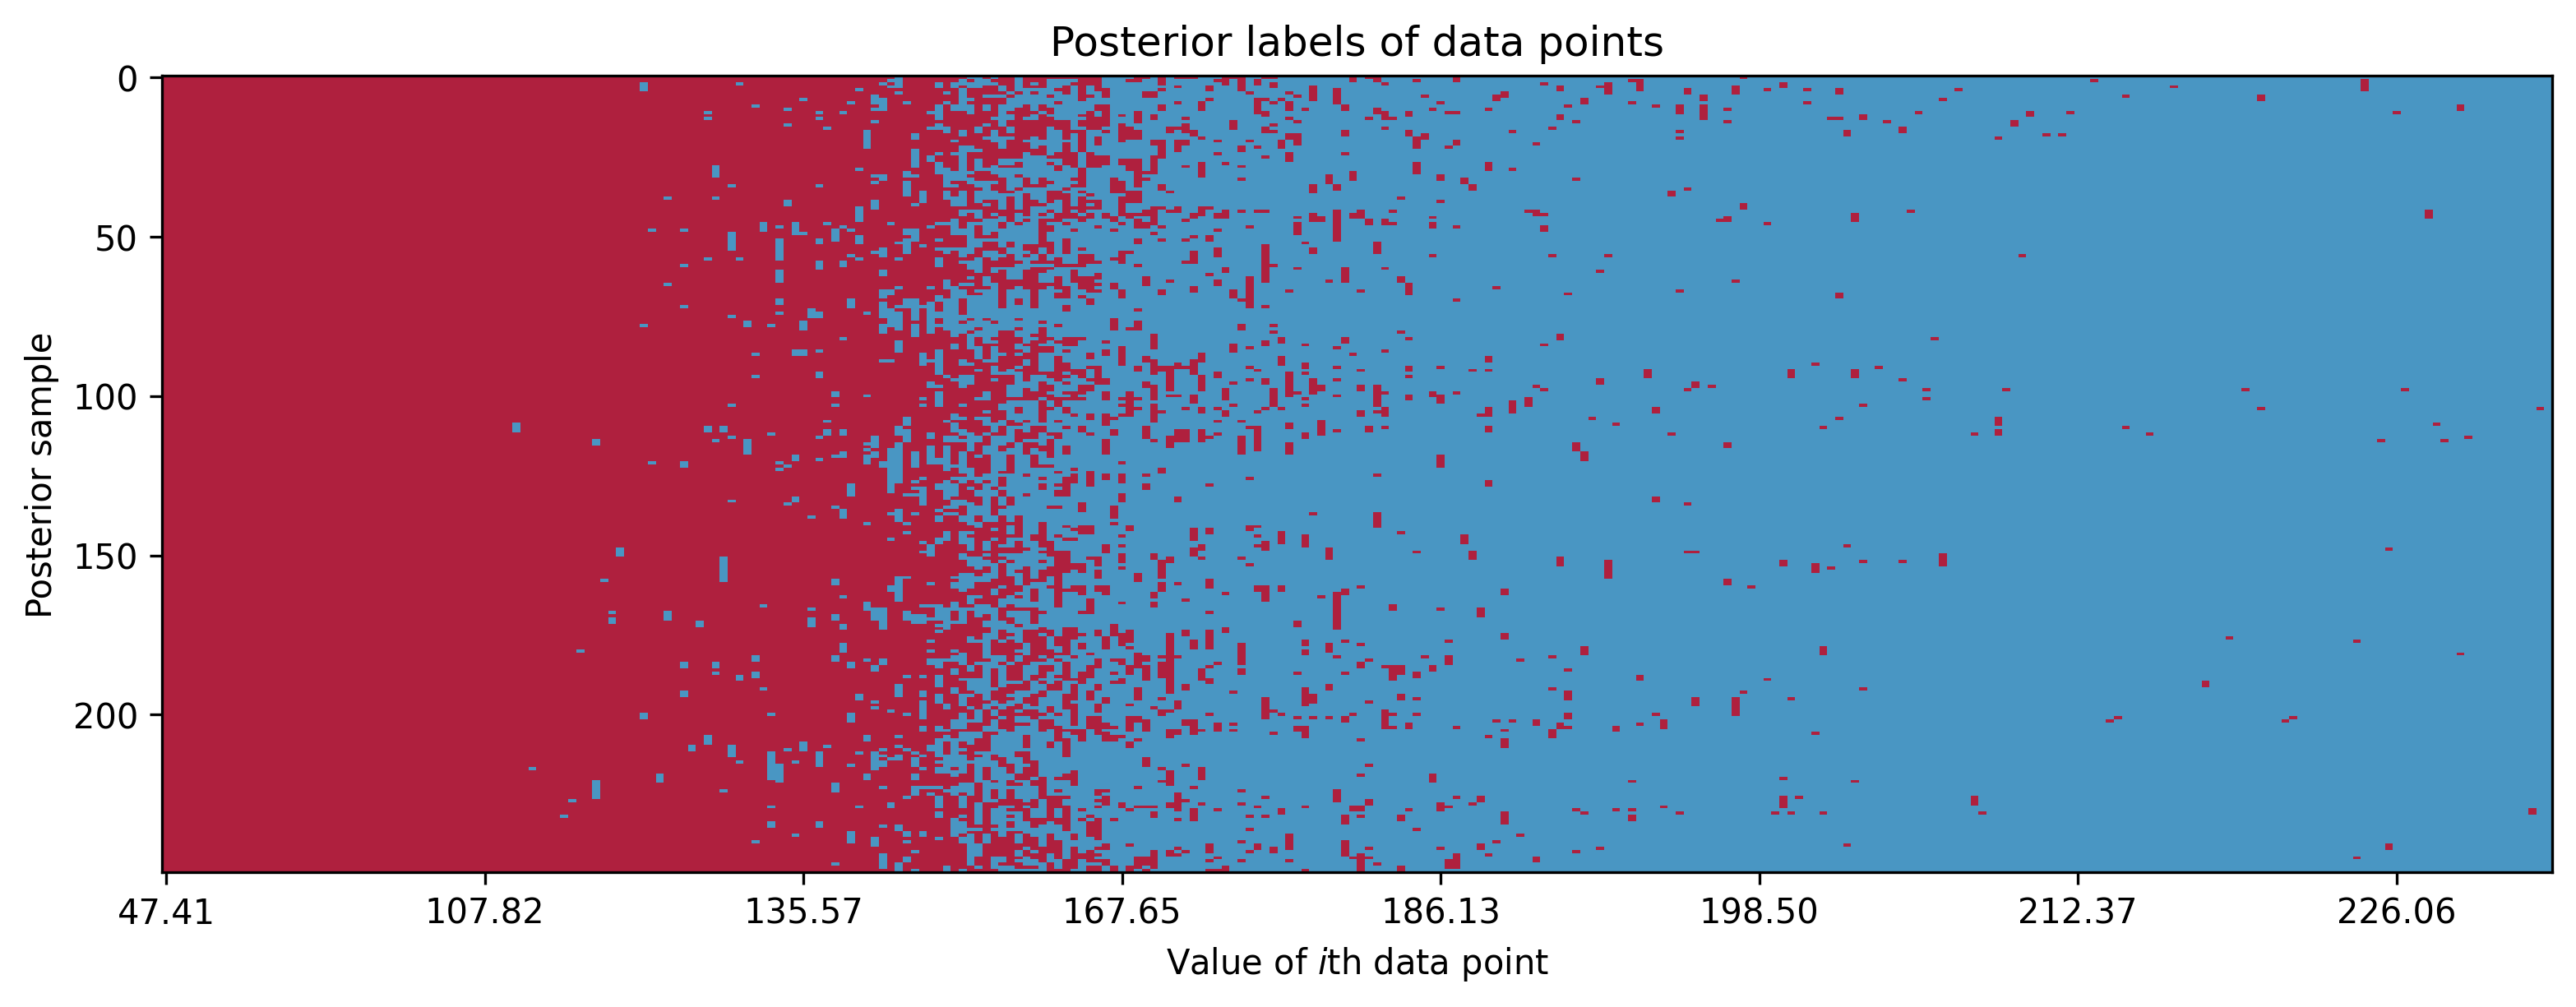

In [23]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(mcmc.trace('assignment')[::400, np.argsort(data)],
           cmap=plt.cmap, aspect=0.4, alpha=0.9)
plt.xticks(np.arange(0, data.shape[0], 40),
           ['{:.2f}'.format(s) for s in np.sort(data)[::40]])
plt.ylabel('Posterior sample')
plt.xlabel('Value of $i$th data point')
plt.title('Posterior labels of data points');

The plot below shows the estimated *frequency* of each data point belonging to the cluster 0 and 1.

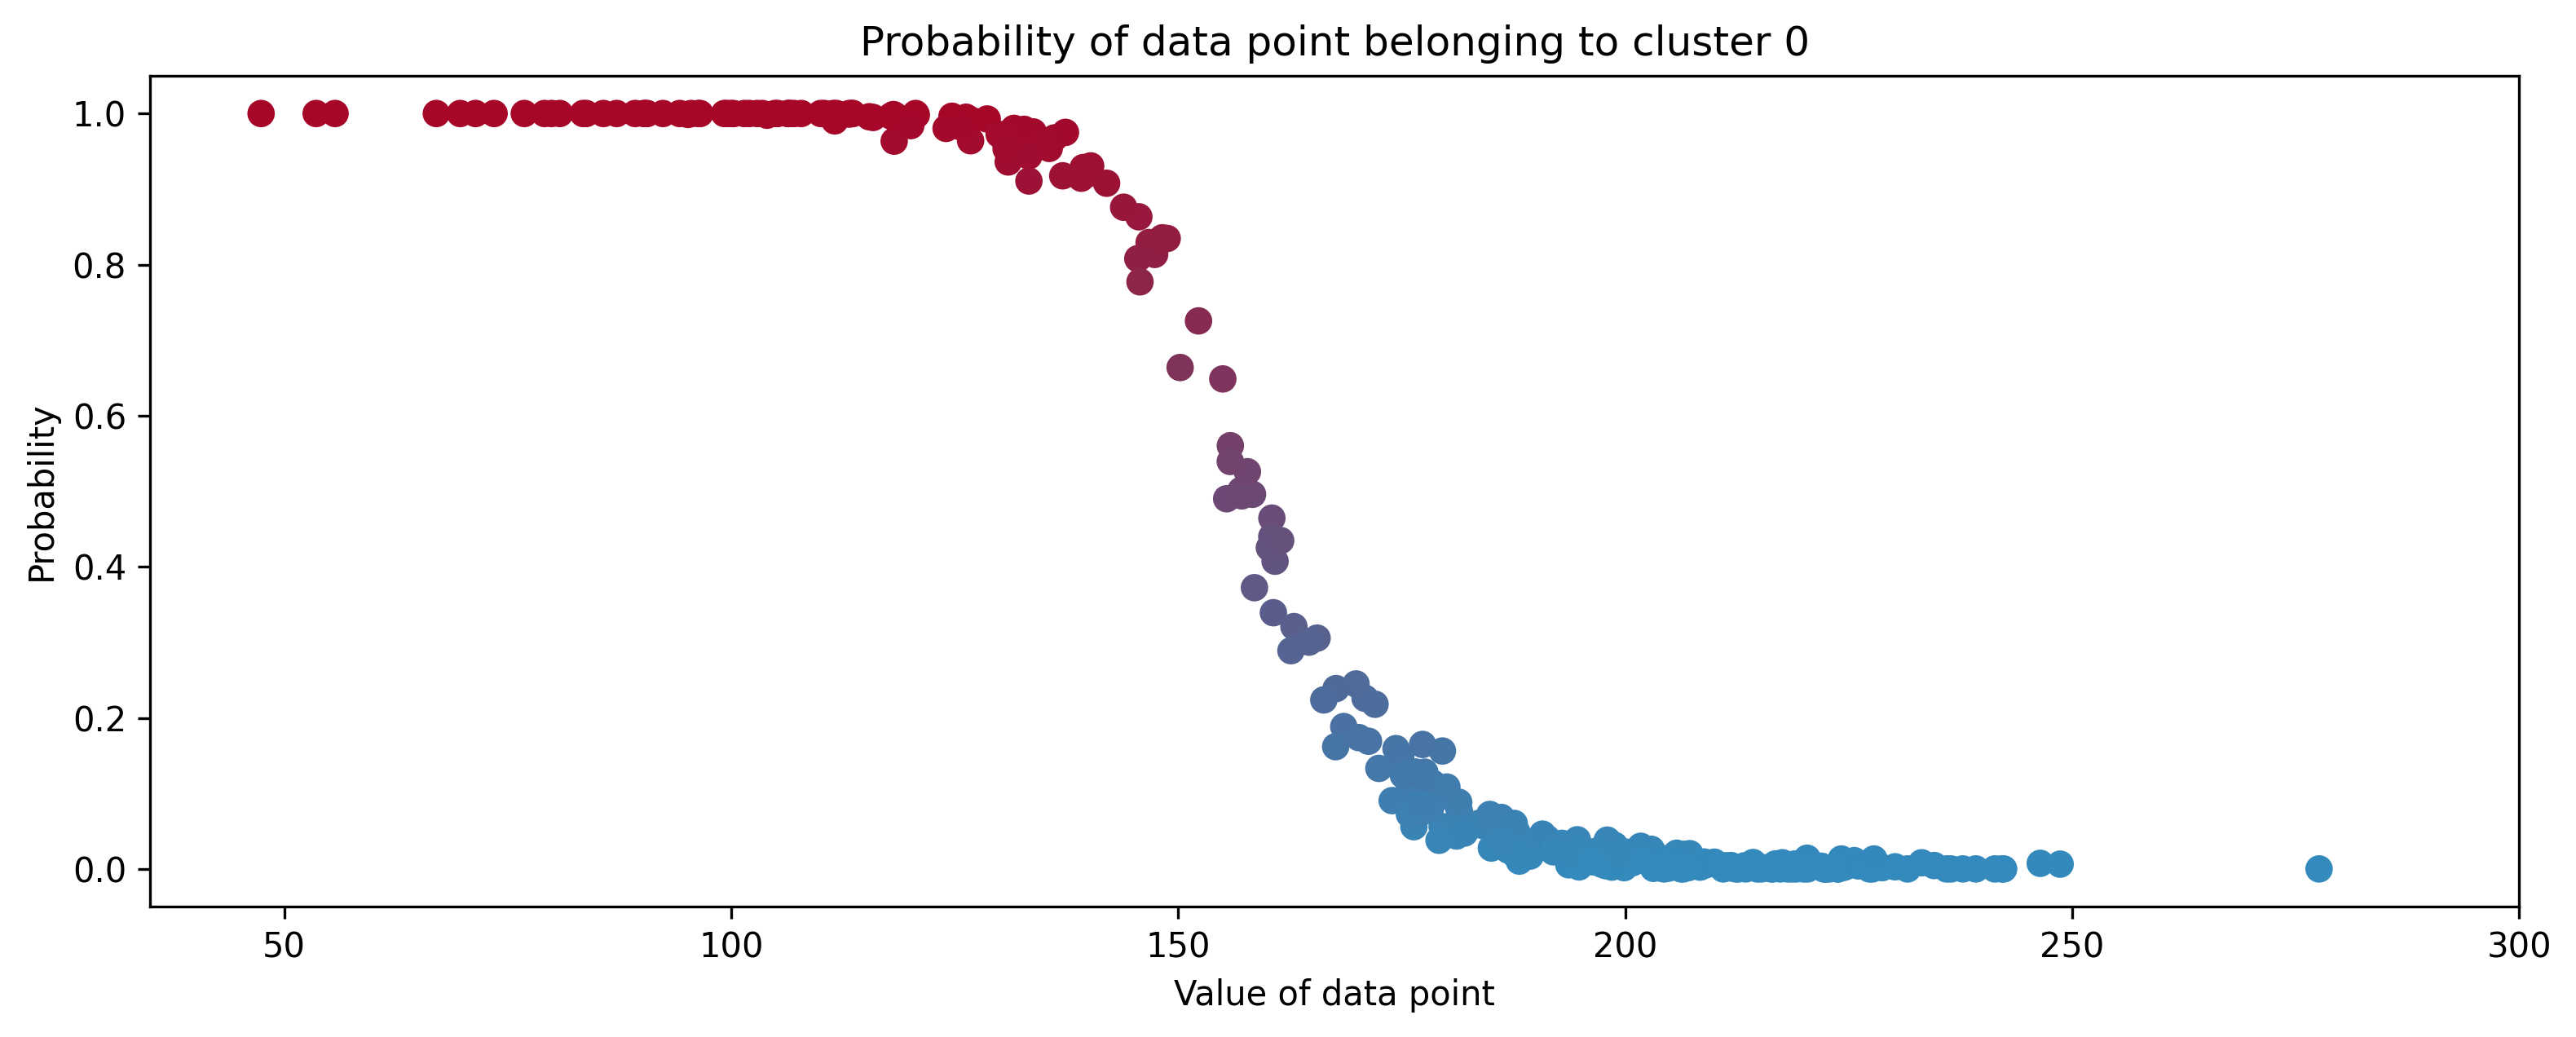

In [24]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('BMH', colors)
assign_trace = mcmc.trace('assignment')[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
            c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title('Probability of data point belonging to cluster 0')
plt.ylabel('Probability')
plt.xlabel('Value of data point');

To choose a single pair of values for the mean and variance and determine a *sorta-best-fit* Gaussian distributions, we can use the *mean* of the posterior distributions. The plot below shows the Normal density functions are overlayed using the mean of the posterior distributions as the chosen parameters with observed data:

In [25]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace('p')[:].mean()

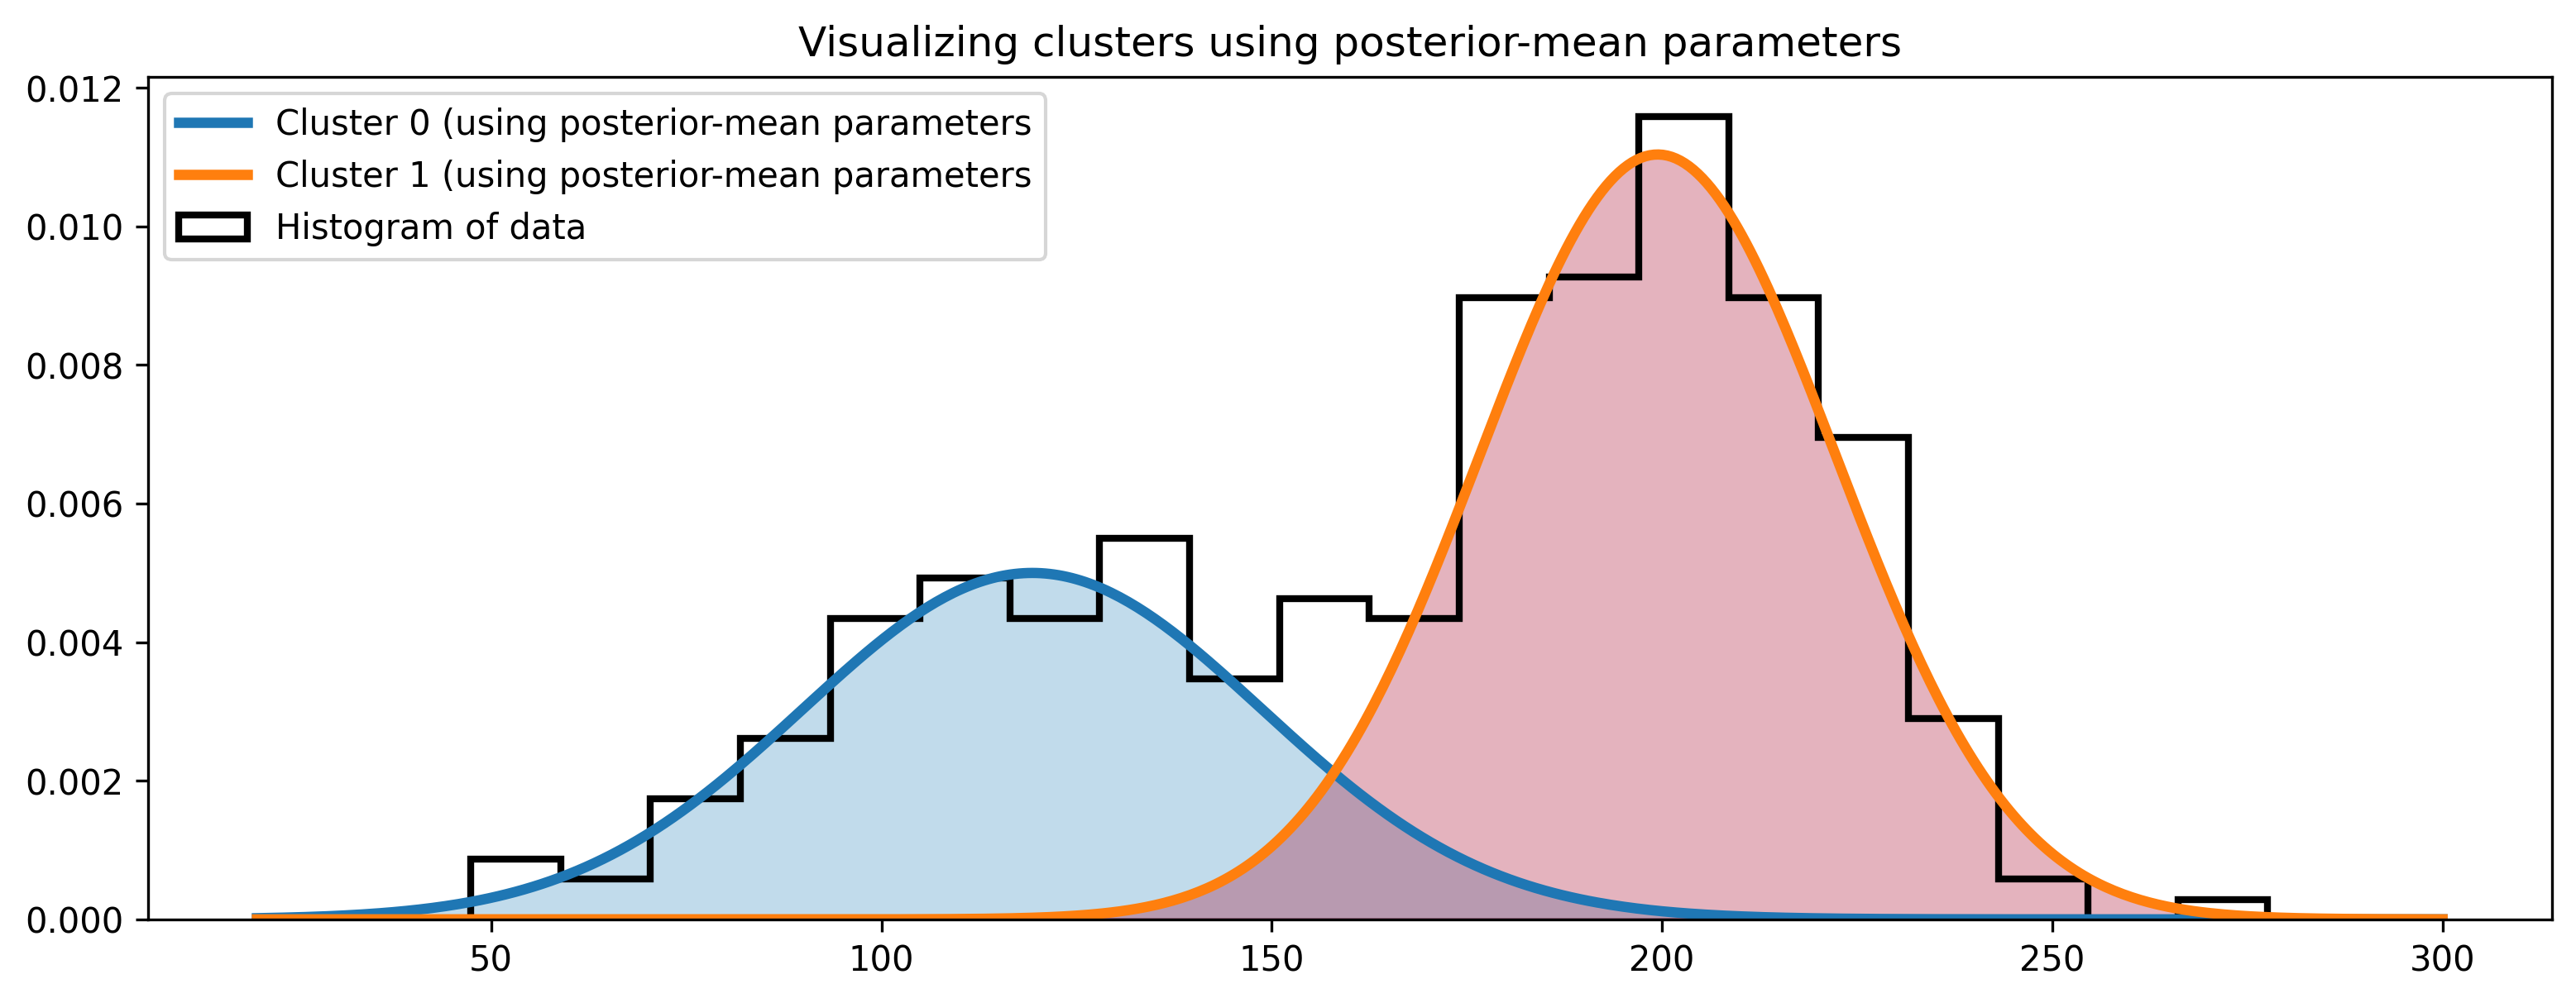

In [26]:
plt.hist(data, bins=20, histtype='step', density=True, color='k',
         lw=2, label='Histogram of data')
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label='Cluster 0 (using posterior-mean parameters', lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label='Cluster 1 (using posterior-mean parameters', lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)
plt.legend(loc='upper left')
plt.title('Visualizing clusters using posterior-mean parameters');

All the unknowns are related in a similar manner. If a standard deviation is large, then the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area.

Suppose two variables, $x$ and $y$, are related by $x+y=10$. In the plot below, $x$ is model as a Normal random variable with mean 4 and explore 500 samples:

In [27]:
x = pm.Normal('x', 4, 10)
y = pm.Lambda('y', lambda x=x: 10-x, trace=True)

In [28]:
ex_mcmc = pm.MCMC(pm.Model([x, y]))
ex_mcmc.sample(500)

 [-----------------100%-----------------] 500 of 500 complete in 0.0 sec

/usr/local/lib/python3.6/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


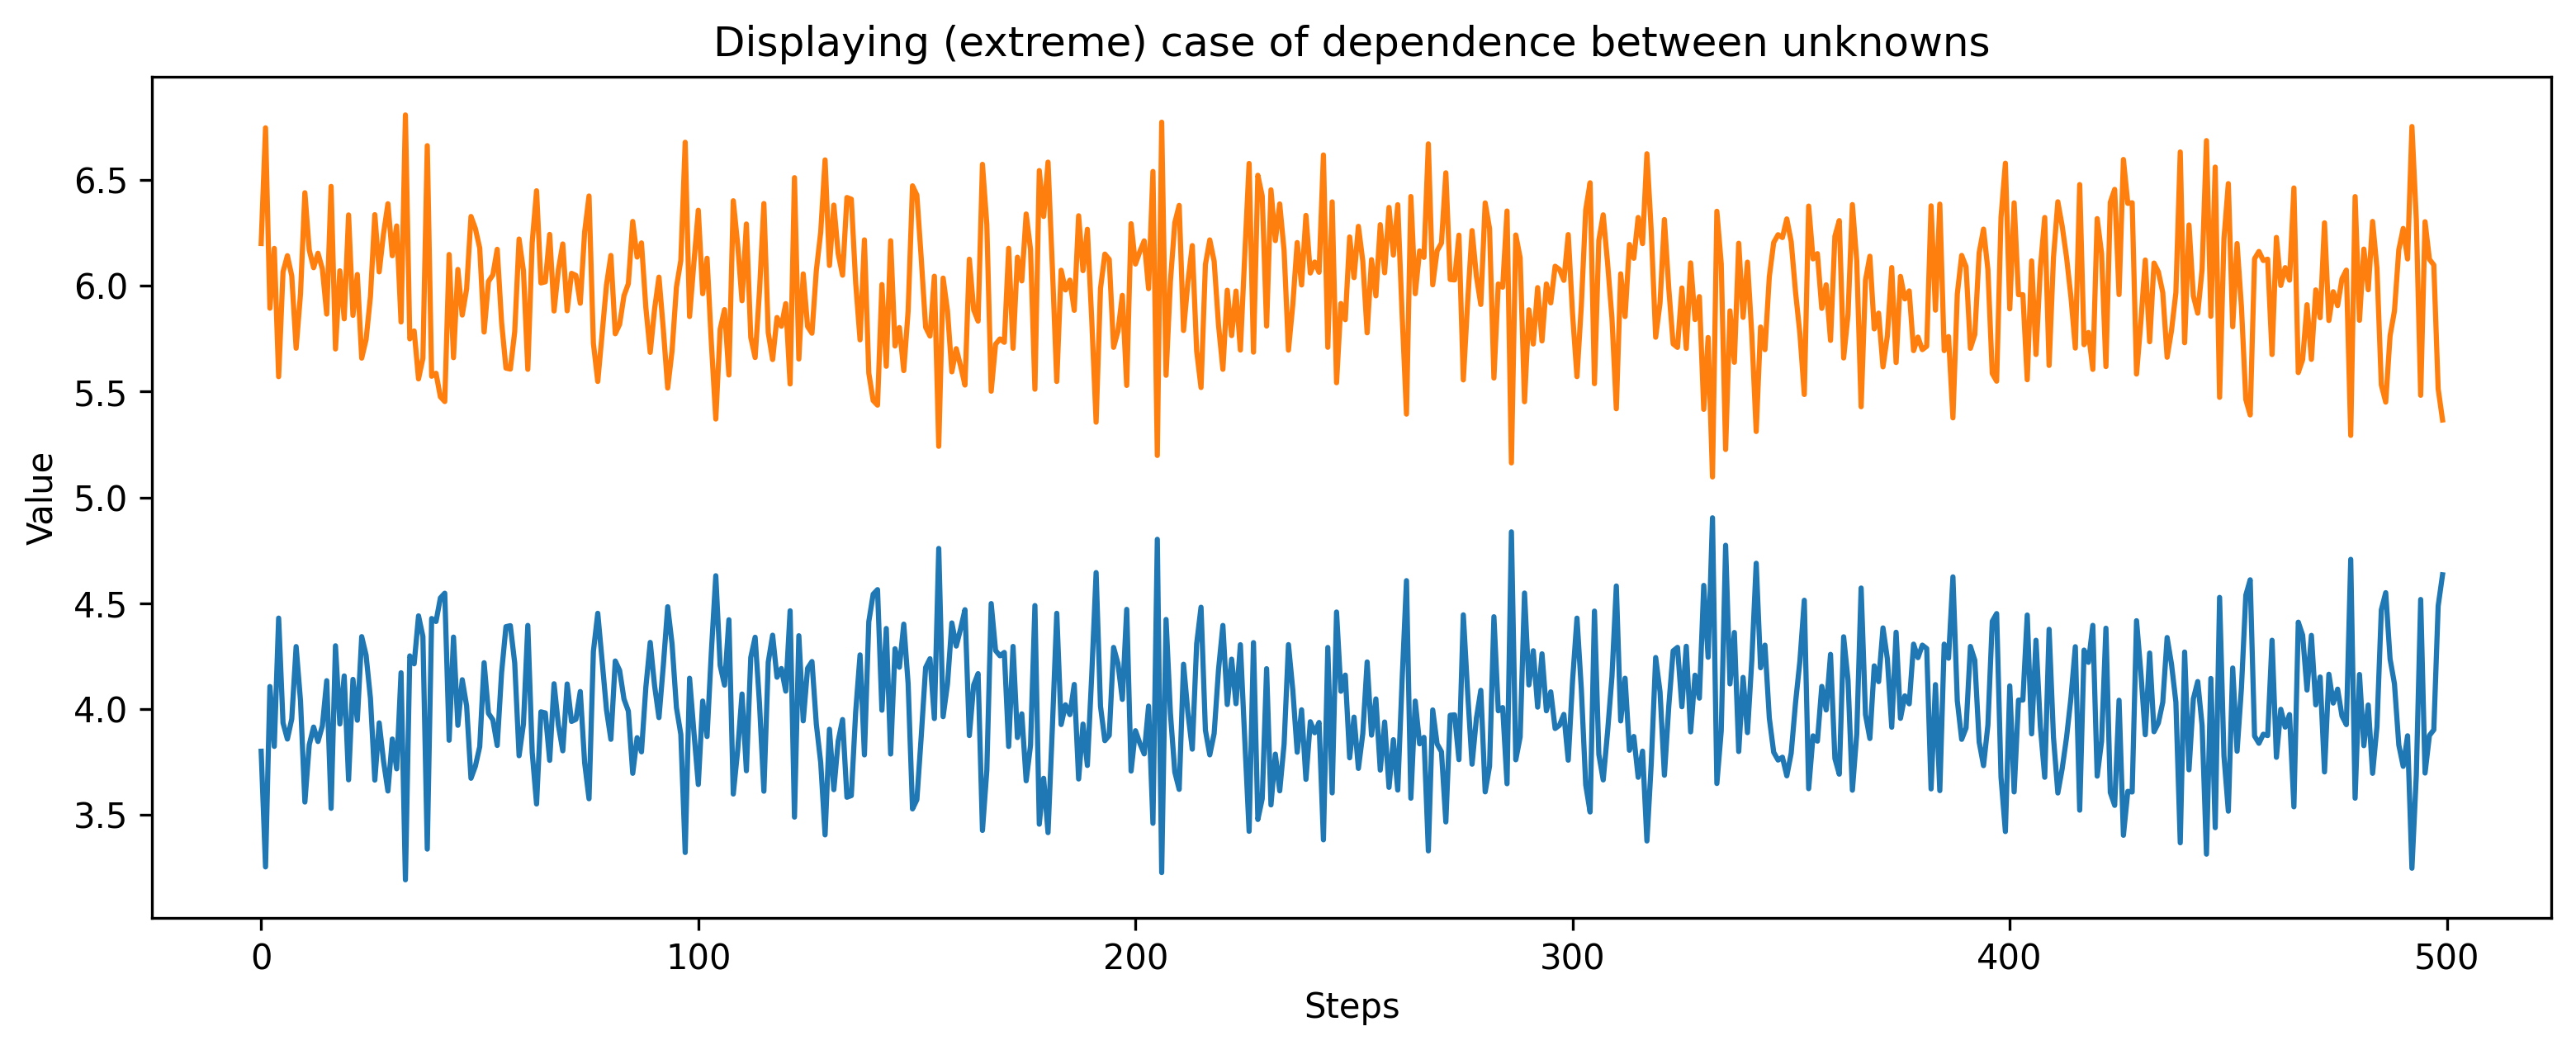

In [29]:
plt.plot(ex_mcmc.trace('x')[:])
plt.plot(ex_mcmc.trace('y')[:])
plt.xlabel('Steps')
plt.ylabel('Value')
plt.title('Displaying (extreme) case of dependence between unknowns');

These two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i=j$. 

The preceding clustering can be generailzed to $k$ clusters. $k=2$ lets us to visualize the MCMC better.

In [32]:
norm_pdf = stats.norm.pdf
p_trace = mcmc.trace('p')[:]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0],
                       scale=std_trace[:, 0]) > \
    (1-p_trace) * norm_pdf(x, loc=center_trace[:,1],
                           scale=std_trace[:, 1])
    
print('Probability of belonging to cluster 1: {}'.format(v.mean()))

Probability of belonging to cluster 1: 0.0


###Using `MAP` to improve convergence

The MAP method is *maximum a posterior*. PyMC provides an object that will approximate, if not find, the MAP location. Calling `.fit()` from the `MAP` instance sets the variables in the model to their MAP values.

In [34]:
map_ = pm.MAP(model)
map_.fit()

The default optimization algorithm in the call to `fit` is SciPy's `fmin` algorithm

It is a good idea to provide a burn-in period, even if using `MAP` prior to calling `MCMC.sample`, just to be safe. PyMC can automatically discard the first $n$ samples by specifying the `burn` paramter in the call to `sample`:

In [ ]:
model = pm.Model([p, stds, taus, assignment, centers])

map_ = pm.MAP(model)
map_.fit() # stores the fitted variables' values map_.value

mcmc = pm.MCMC(model)
mcmc.sample(iter=100000, burn=50000)

##Diagnosing Convergence

###Autocorrelation
**Autocorrelation** is a measure of how related a series of numbers is to itself. A measurement of 1 is perfect positive autocorrelation, 0 is no autocorrelation, and -1 is perfect negative autocorrelation.

Autocorrelation is how correlated a series, $x_{\tau}$, at time $t$ is with the same series at time $t-k$:
$$R(k)=Corr(x_t, x_{t-k})$$
Consider two series
$$x_t\sim Normal(0,1),\quad x_0=0$$
$$y_t\sim Normal(y_{t-1},1),\quad y_0=0$$
which have example paths like:

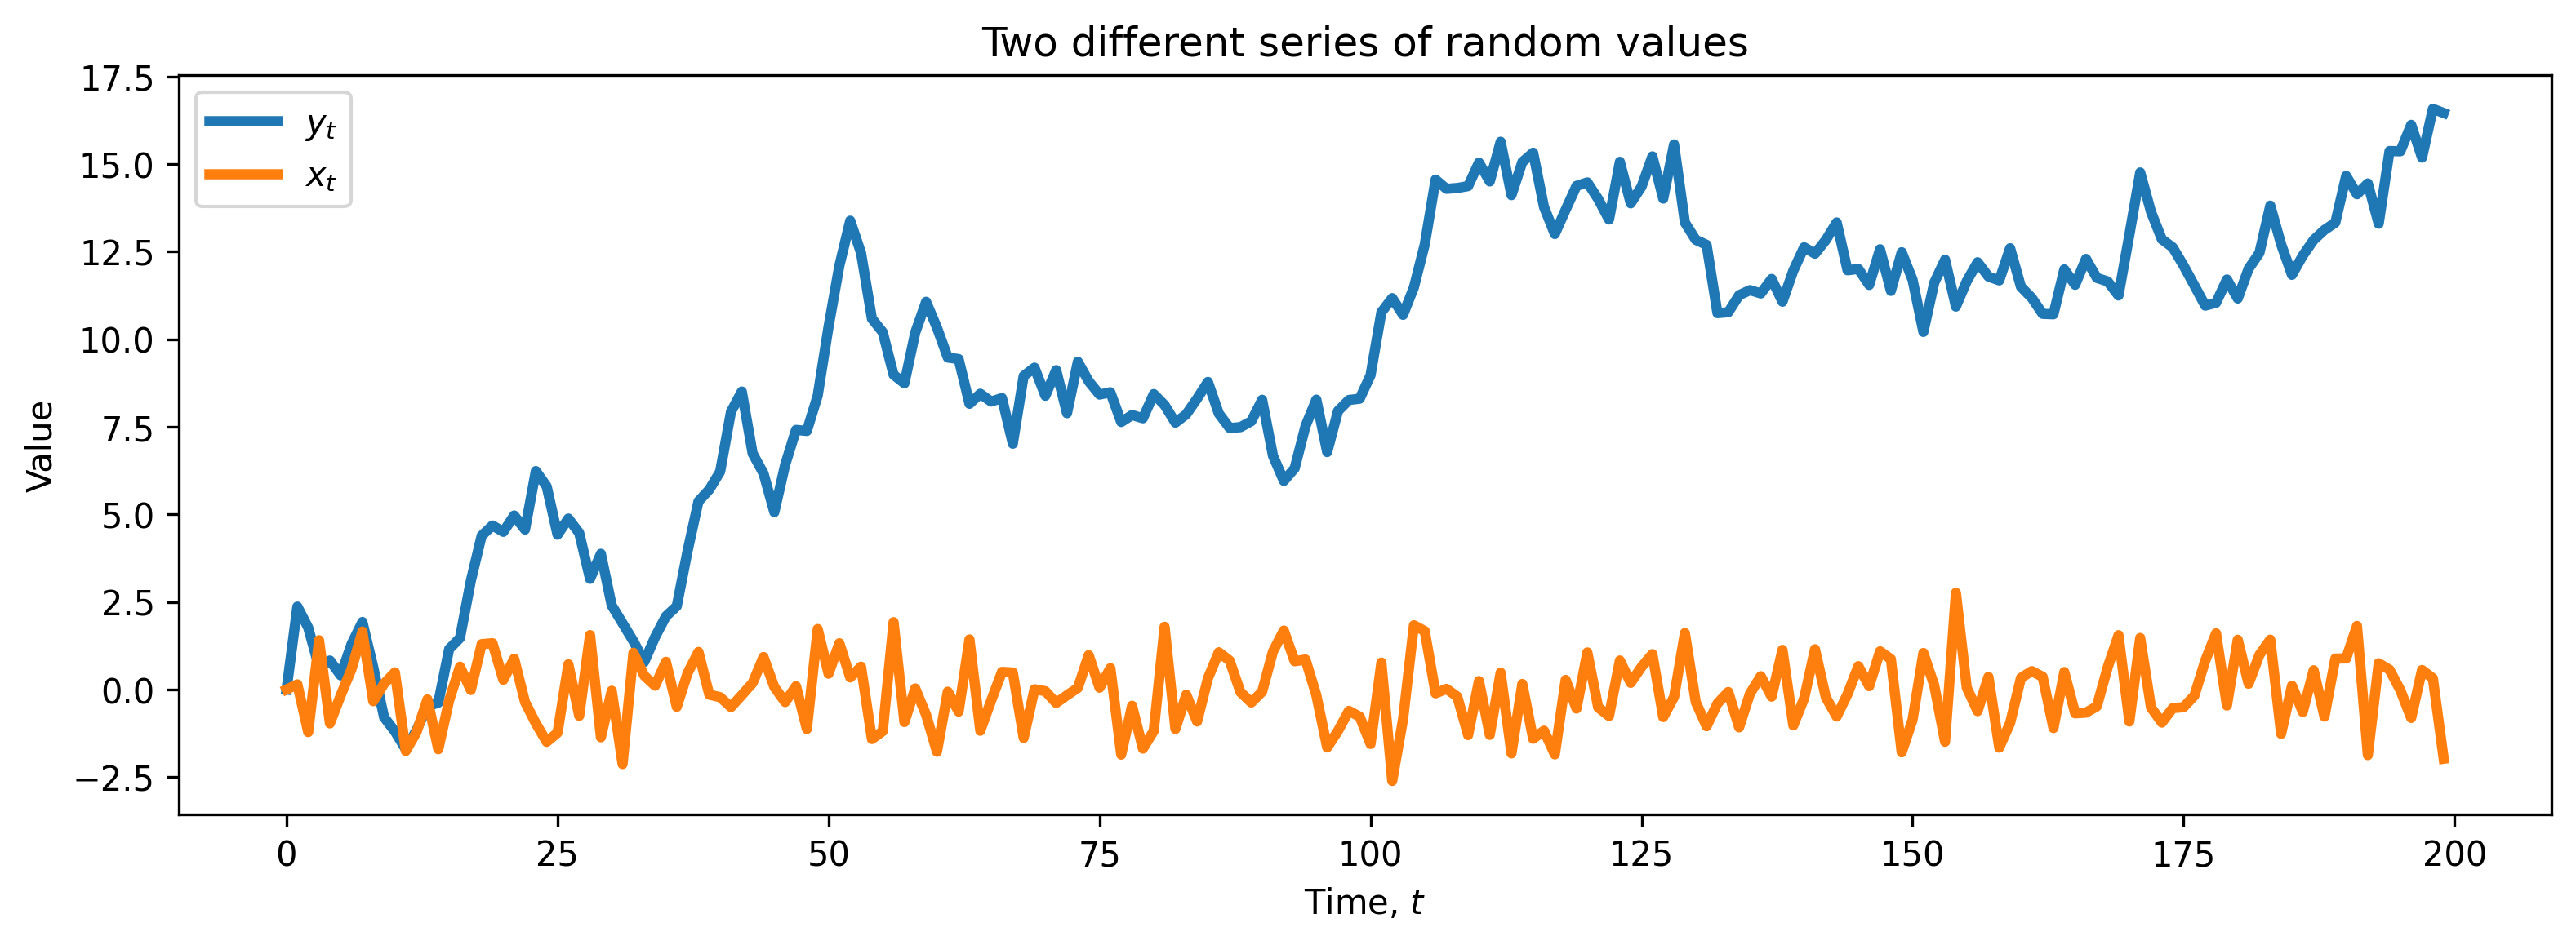

In [38]:
x_t = pm.rnormal(0,1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = pm.rnormal(y_t[i-1], 1)

figsize(12.5, 4)
plt.plot(y_t, label='$y_t$', lw=3)
plt.plot(x_t, label='$x_t$', lw=3)
plt.xlabel('Time, $t$')
plt.ylabel('Value')
plt.title('Two different series of random values')
plt.legend();

In this case, the series $x_t$ is not autocorrelated, but $y_t$ is autocorrelated.

In [41]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

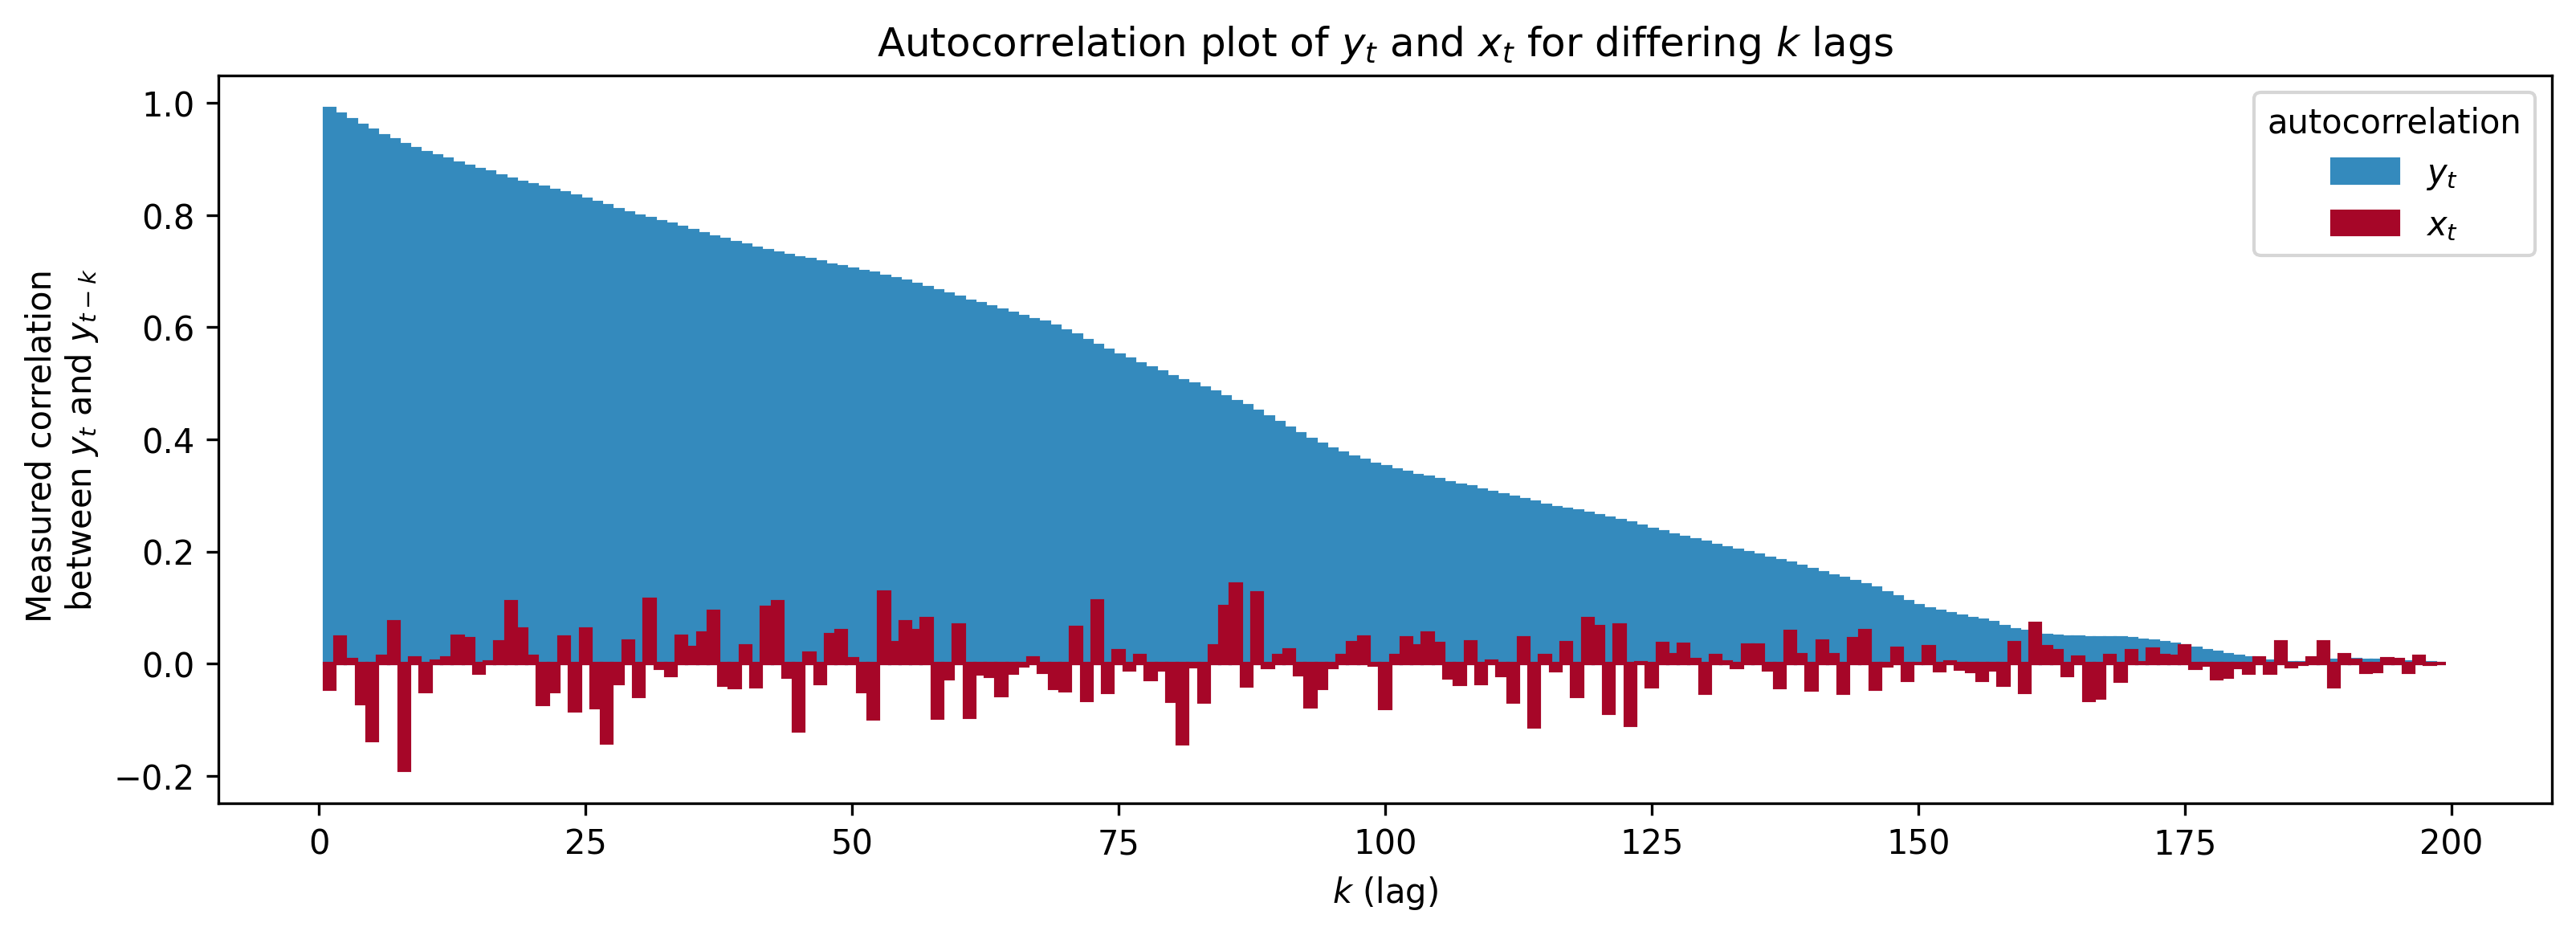

In [42]:
colors = ["#348ABD", "#A60628", "#7A68A6"]
x = np.arange(1, 200)

plt.bar(x, autocorr(y_t)[1:], width=1, label='$y_t$',
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label='$x_t$',
        edgecolor=colors[1], color=colors[1])
plt.legend(title='autocorrelation')
plt.ylabel('Measured correlation \nbetween $y_t$ and $y_{t-k}$')
plt.xlabel('$k$ (lag)')
plt.title('Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags');

As $k$ increases, the autocorrelation of $y_t$ decreases from a very high point, unlike the autocorrelation of $x_t$ which looks like noise.

###Thinning
Thinning is the process that The autocorrelation can be reduced by only returning every $n$th sample.

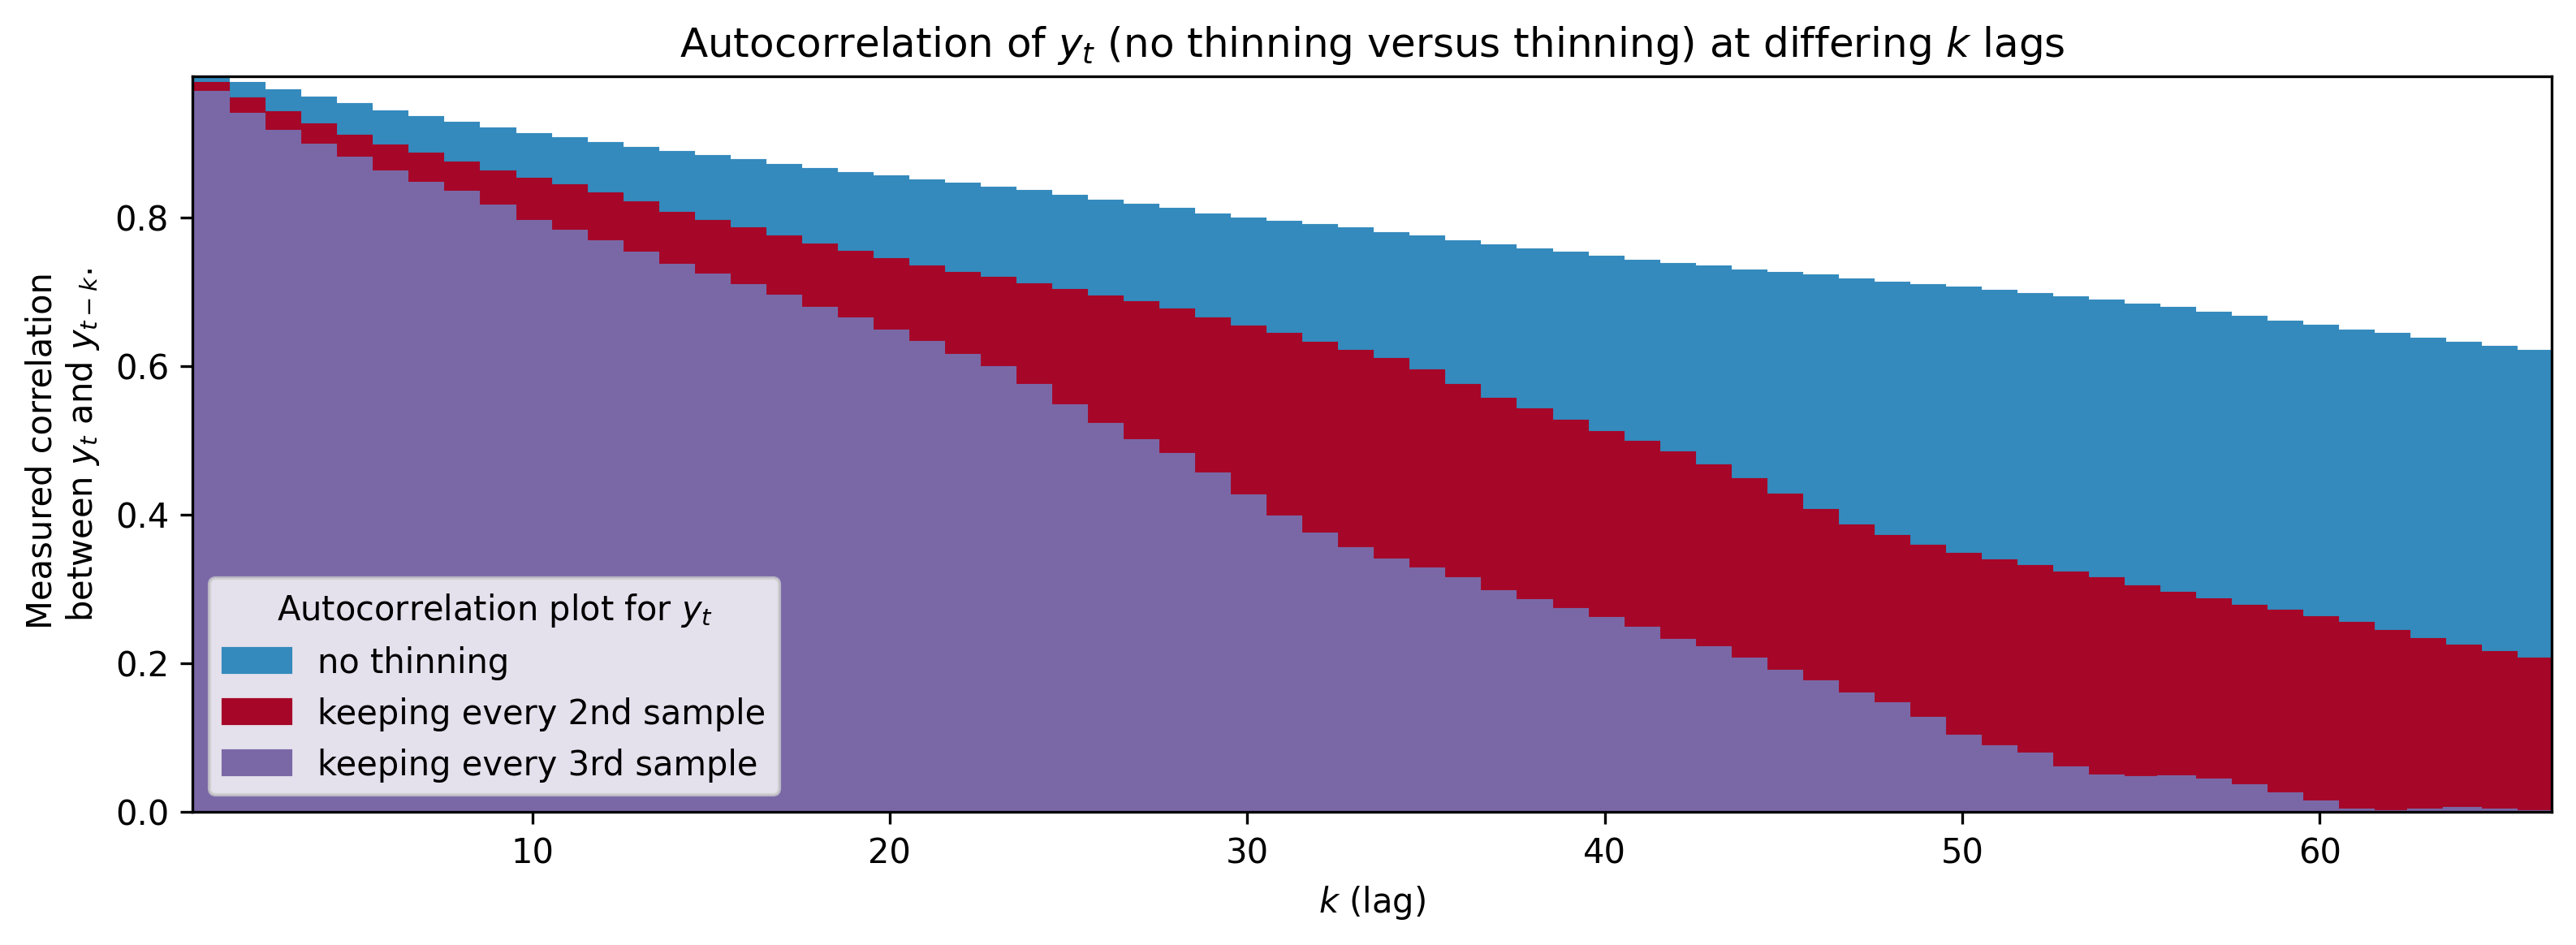

In [43]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label='no thinning', color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label='keeping every 2nd sample', color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], edgecolor=colors[2], 
        label="keeping every 3rd sample", color=colors[2], width=1)

plt.autoscale(tight=True)
plt.legend(title='Autocorrelation plot for $y_t$', loc='lower left')
plt.ylabel('Measured correlation \nbetween $y_t$ and $y_{t-k}$.')
plt.xlabel('$k$ (lag)')
plt.title('Autocorrelation of $y_t$ (no thinning versus thinning) at differing $k$ lags');

With more thinning, the autocorrelation drops more quickly. However, there is a trade-off:

Higher thinning requires more MCMC iterations to achieve the same number of returned samples.

As long as the autocorrelation tends to 0 quickly, it is a okay number for thinning.

PyMC exposes a `thinning` parameter in the call to `sample`

In [ ]:
mcmc.sample(iter=10000,
            burn=5000,
            thin=5)

###`pymc.Matplot.plot()`

In [44]:
from pymc.Matplot import plot as mcplot

 [-----------------100%-----------------] 25000 of 25000 complete in 7.8 secPlotting centers_0
Plotting centers_1


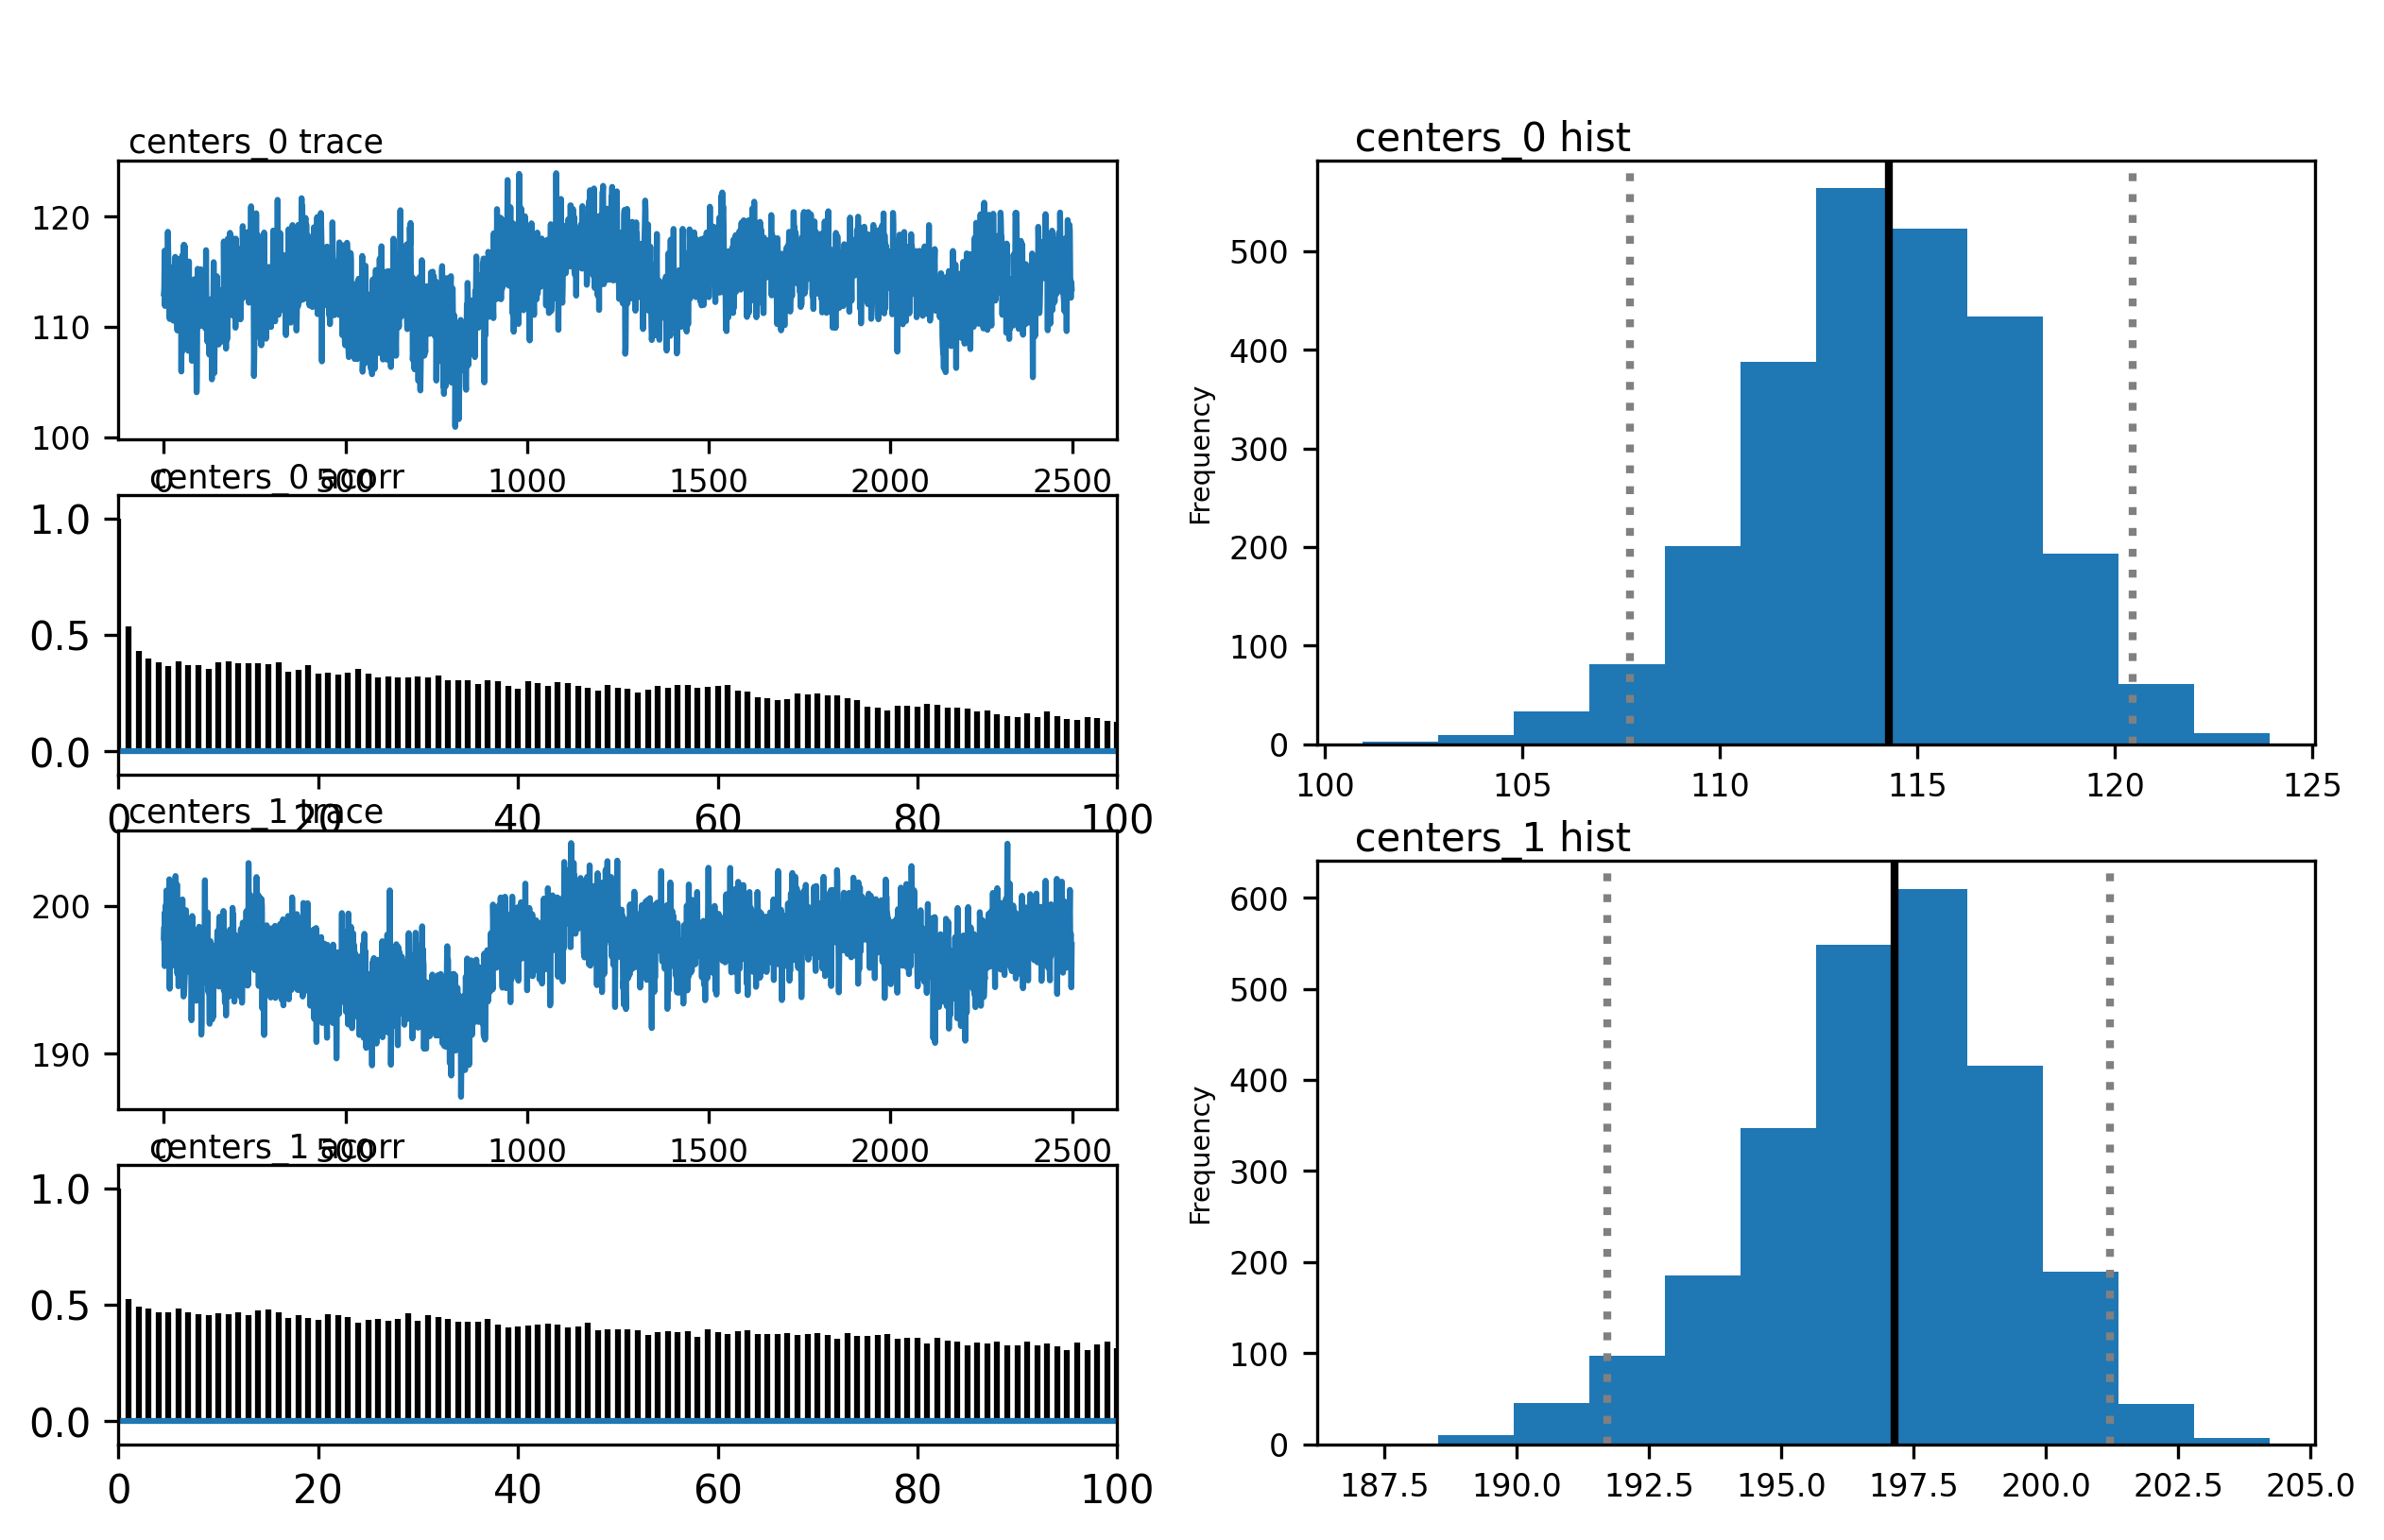

In [45]:
mcmc.sample(25000, 0, 10)
mcplot(mcmc.trace('centers', 2), common_scale=False)

One of each unknown in the `centers` variables is plotted.

##Useful tips for MCMC

###Intelligent starting values
If we have data from a Normal distribution, and wish to estimate the $\mu$ parameter, then a good starting value would be the *mean* of the data:

In [ ]:
mu = pm.Uniform('mu', 0, 100, value=data.mean())

There are frequentist estimates for most parameters in models. These estimates are a good starting value for MCMC.

#PyMC3

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


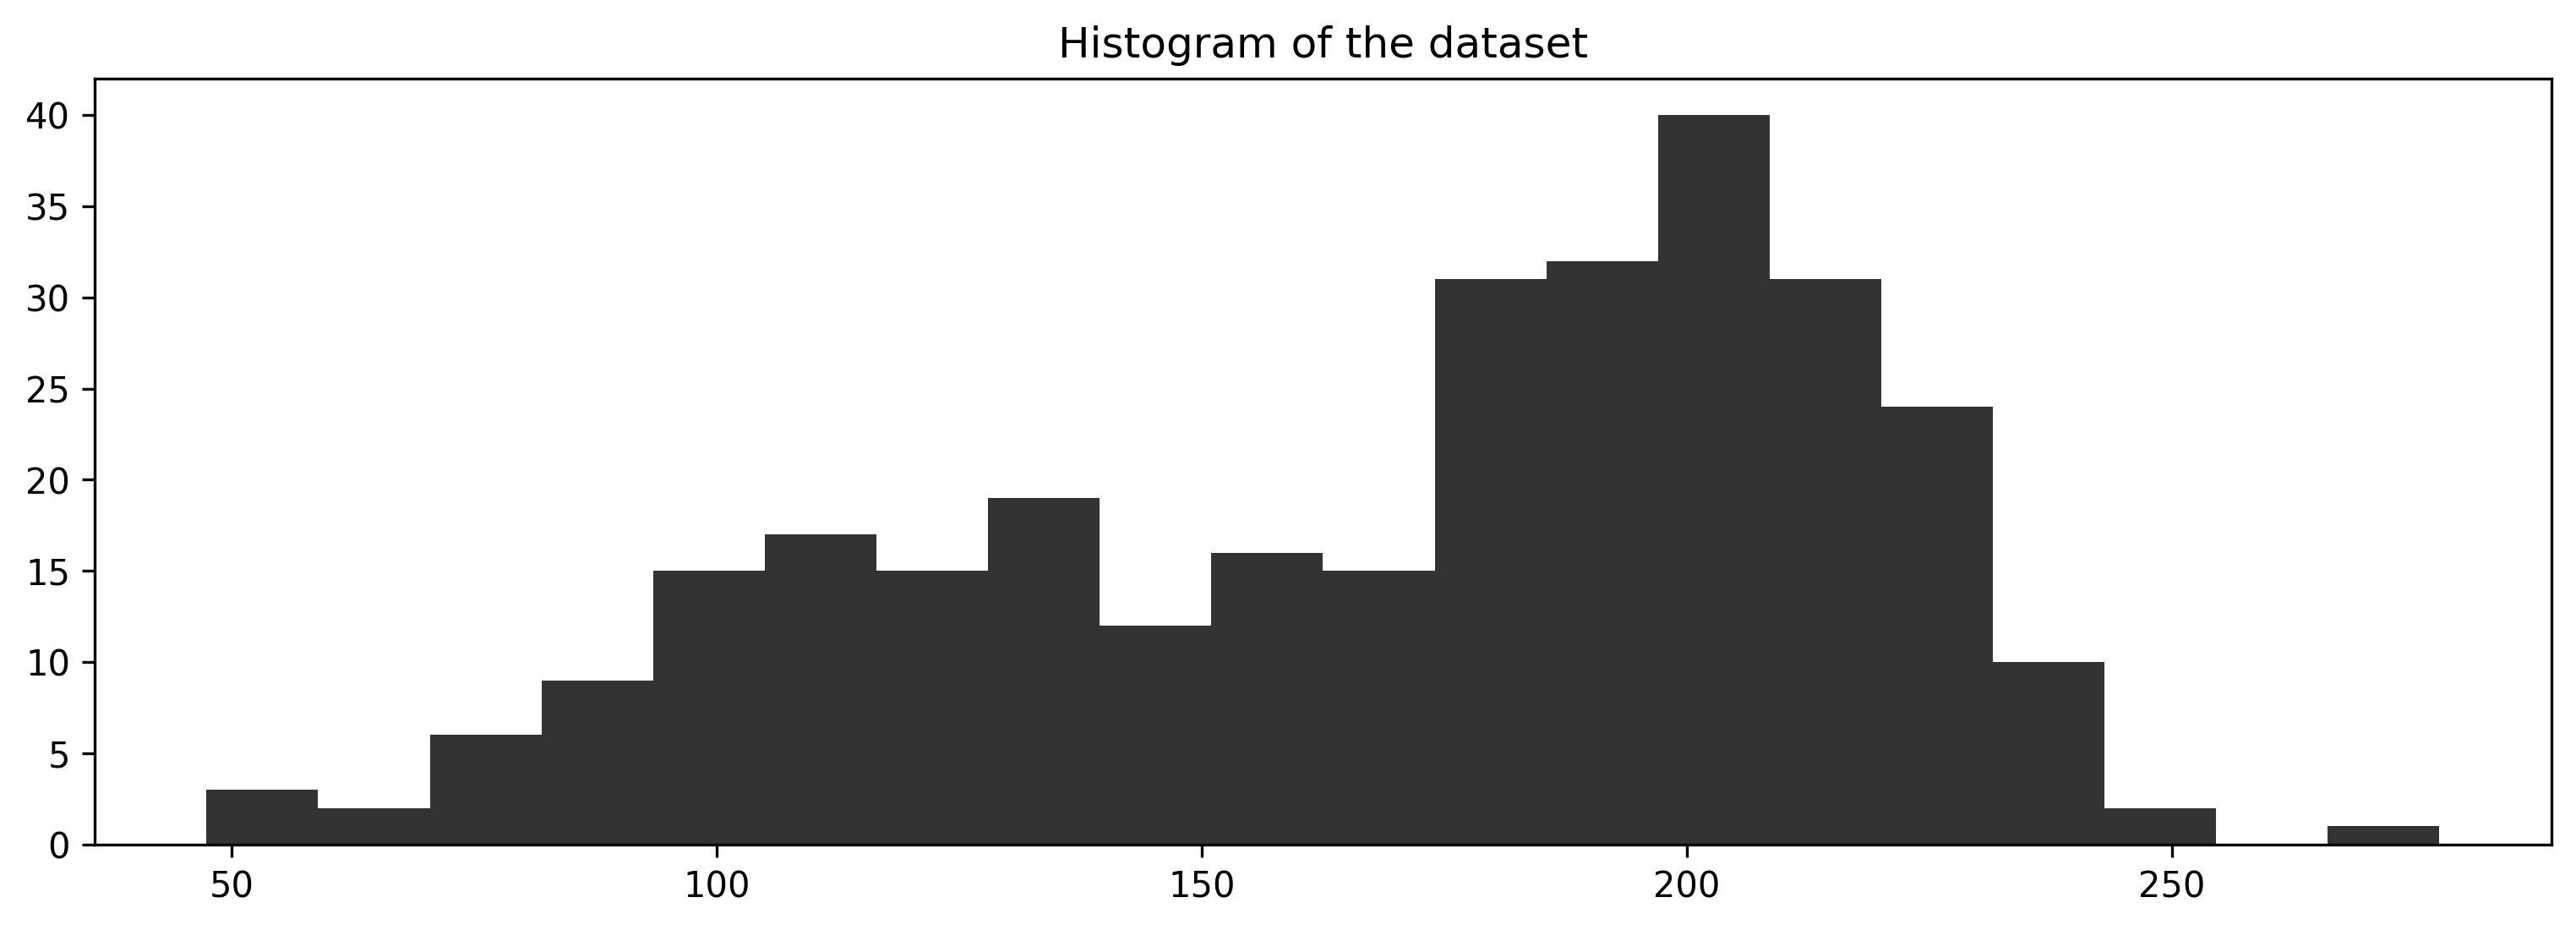

In [46]:
# data still from above sections
figsize(12.5, 4)

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

In [47]:
import pymc3 as pm
import theano.tensor as T

In [49]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                                shape=data.shape[0],
                                testval=np.random.randint(0,2,data.shape[0]))

print('prior assignment, with p = {:.2f}:'.format(p1.tag.test_value))
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[1 0 1 1 1 1 1 1 1 1]


In [50]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)
    centers = pm.Normal('centers',
                        mu=np.array([120, 190]),
                        sd=np.array([10, 10]),
                        shape=2)
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])

    # to combine it with the observations:
    observations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)

print('Random assignments: ', assignment.tag.test_value[:4], '...')
print('Assigned center: ', center_i.tag.test_value[:4], '...')
print('Assigned standard deviation: ', sd_i.tag.test_value[:4])

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


Random assignments:  [1 0 1 1] ...
Assigned center:  [190. 120. 190. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


The model is continued to be built within the context of `Model()`.

Similarly, any sampling within the context of `Model()` will be done only on the model whose context in which worked on.

The model will explore the parameter space by defining the sampling methods, in this case `Mettropolis()` for continuous variables and `ElemwiseCategorical()` for categorical variable. All these sampling methods are used on `sample(iterations, step)` method:

In [51]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
100%|██████████| 25500/25500 [03:31<00:00, 120.66it/s]
The number of effective samples is smaller than 10% for some parameters.


The paths of all variables, or "traces" are stored in the `trace` variable.

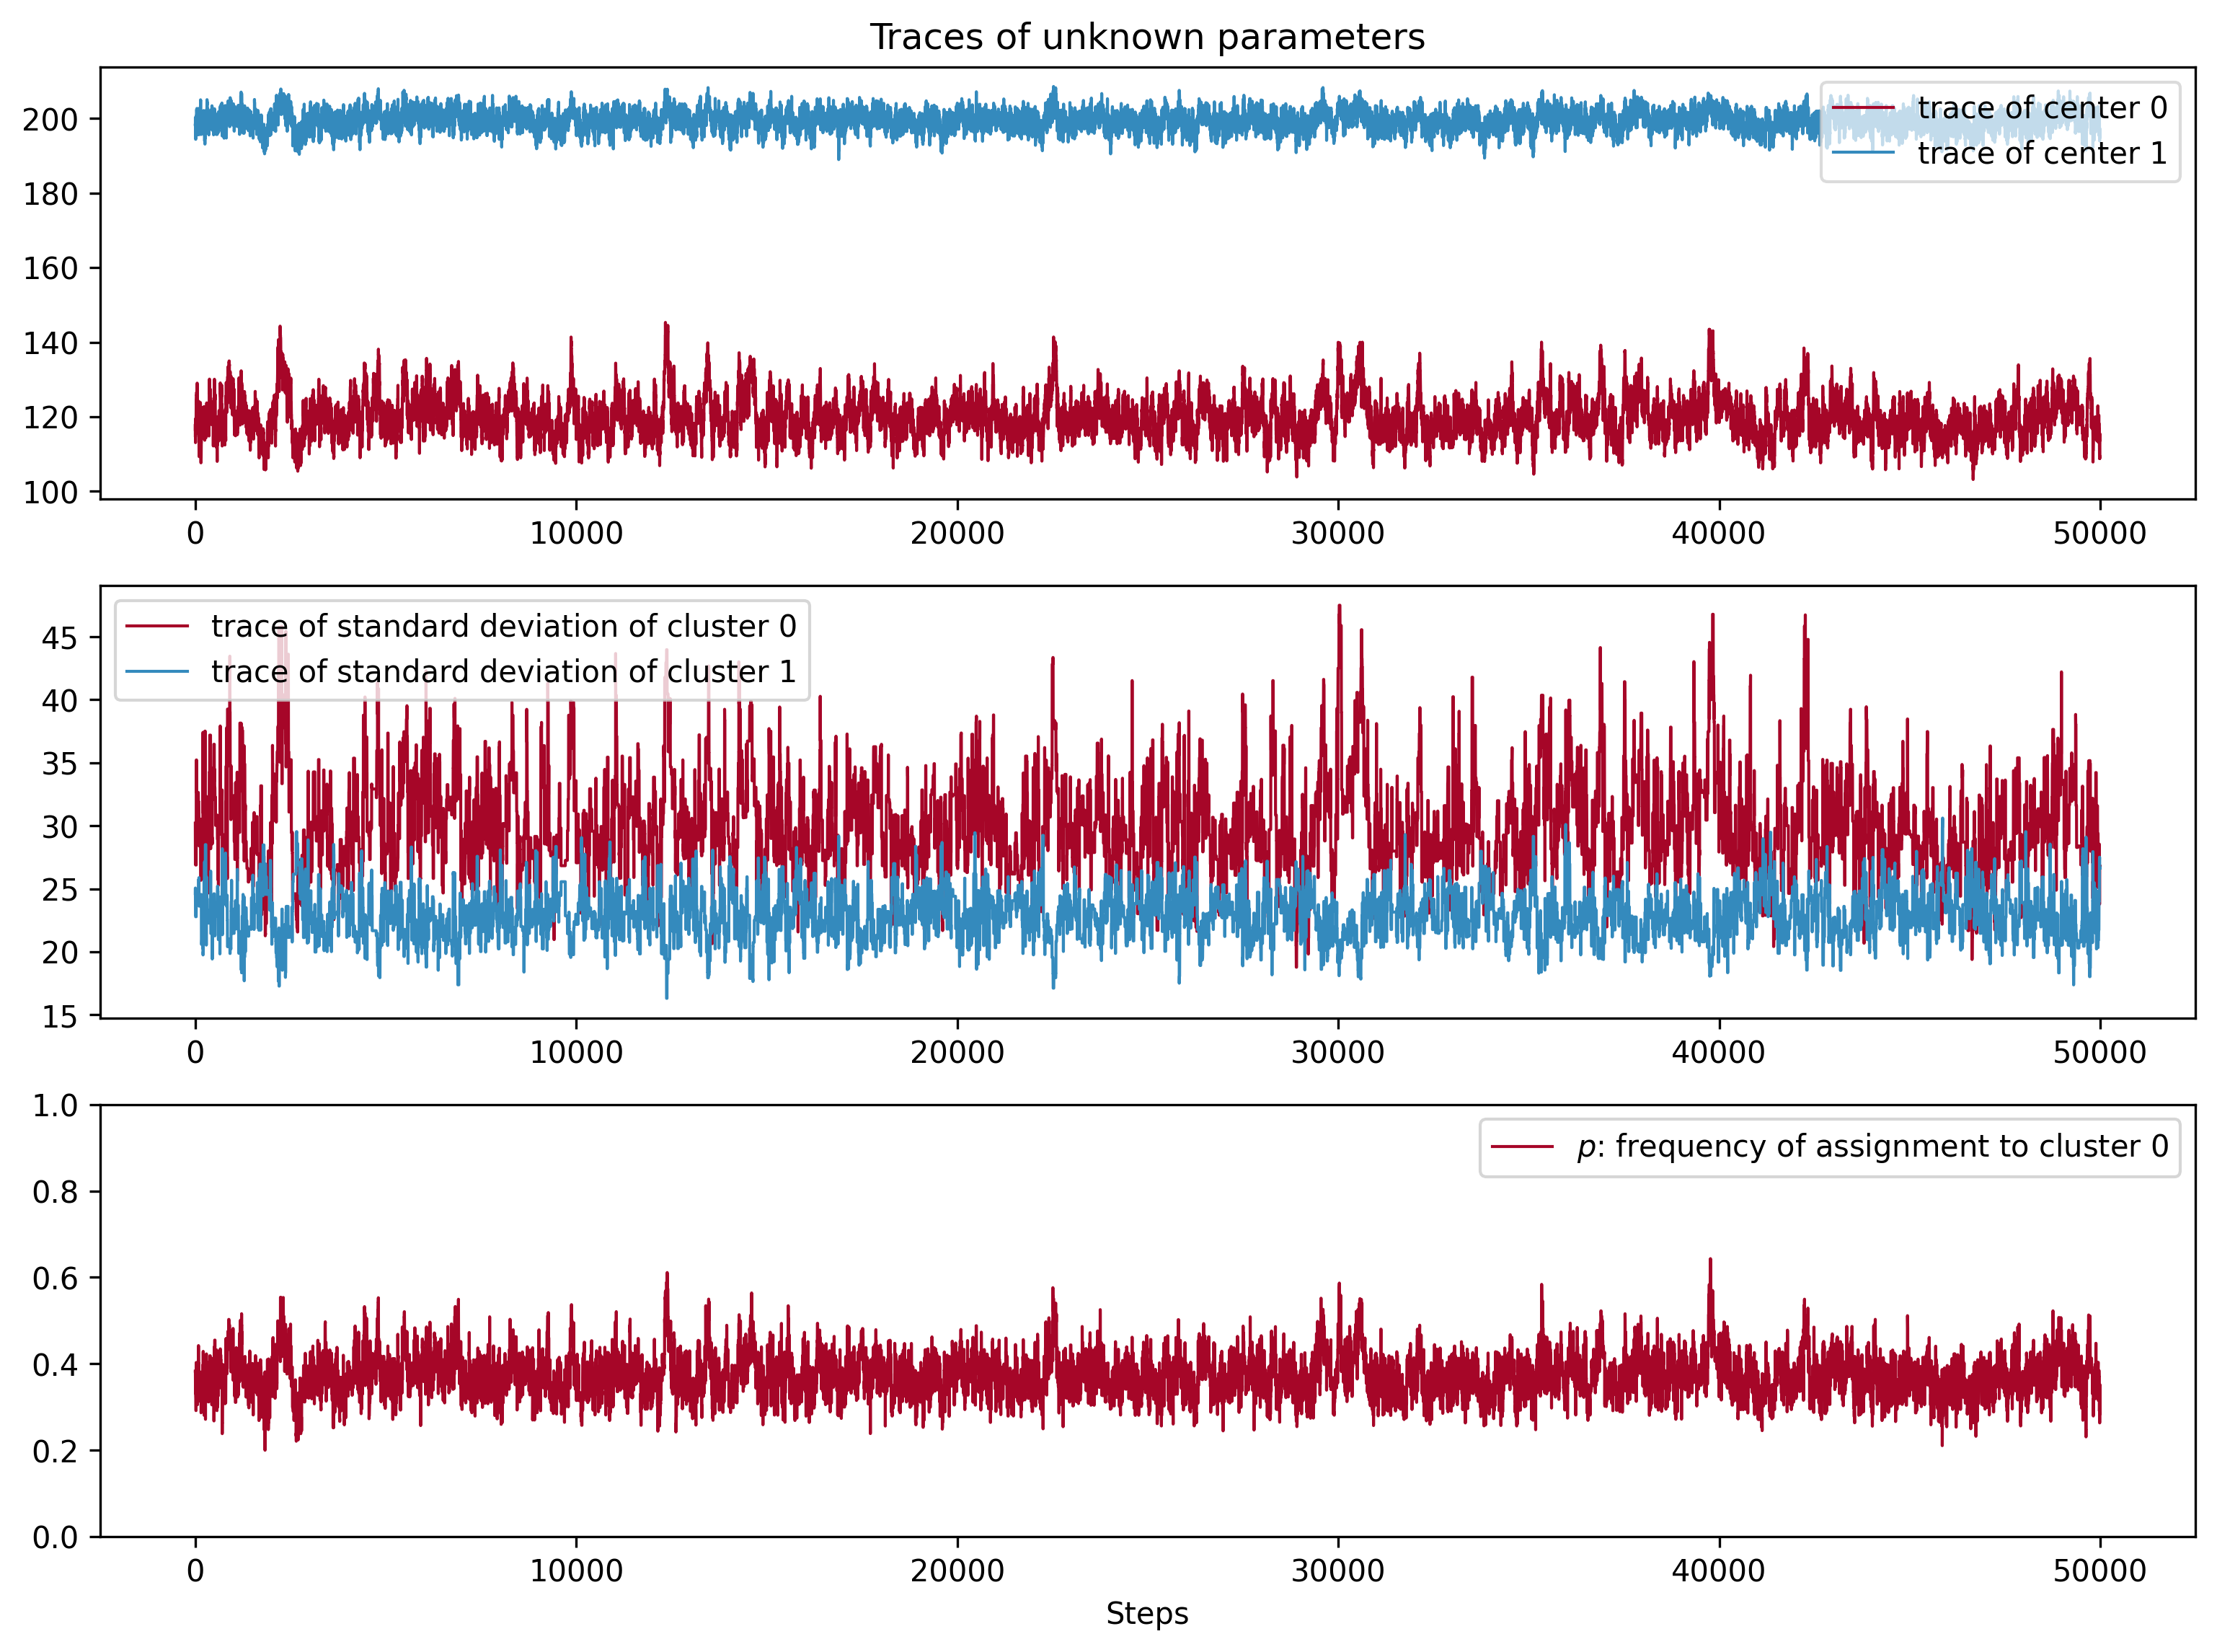

In [52]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace['centers']

# for pretty colors later in the book.
colors = ['#348ABD', '#A60628'] if center_trace[-1, 0] > center_trace[-1, 1] \
                                else ['#A60628', '#348ABD']

plt.plot(center_trace[:, 0], label='trace of center 0', c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label='trace of center 1', c=colors[1], lw=lw)
plt.title('Traces of unknown parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace['sds']
plt.plot(std_trace[:, 0], 
         label='trace of standard deviation of cluster 0',
         c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], 
         label='trace of standard deviation of cluster 1',
         c=colors[1], lw=lw)
plt.legend(loc='upper left')

plt.subplot(313)
p_trace = trace['p']
plt.plot(p_trace, 
         label='$p$: frequency of assignment to cluster 0',
         color=colors[0], lw=lw)
plt.xlabel('Steps')
plt.ylim(0, 1)
plt.legend();

To achieve further convergence, need to perform more MCMC steps. To continue where left off, pass the `trace` into the `sample()` function with the same step value, so the values that already calculated will not be overwritten.

In [ ]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

In [ ]:
figsize(12.5, 4)
center_trace = trace['centers'][25000:]
prev_center_trace = trace['centers'][:25000]

x = np.arange(25000)
plt.plot(x, prev_center_trace[:, 0], label='previous trace of center 0',
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label='previous trace of center 1',
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label='new trace of center 0', lw=lw, c='#348ABD')
plt.plot(x, center_trace[:, 1], label='new trace of center 1', lw=lw, c='#A60628')

plt.title('Traces of unknown center parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.8)
plt.xlabel('Steps');

After determining posterior distributions for unknowns, plot the posterior distributions of the center and standard deviation variables:

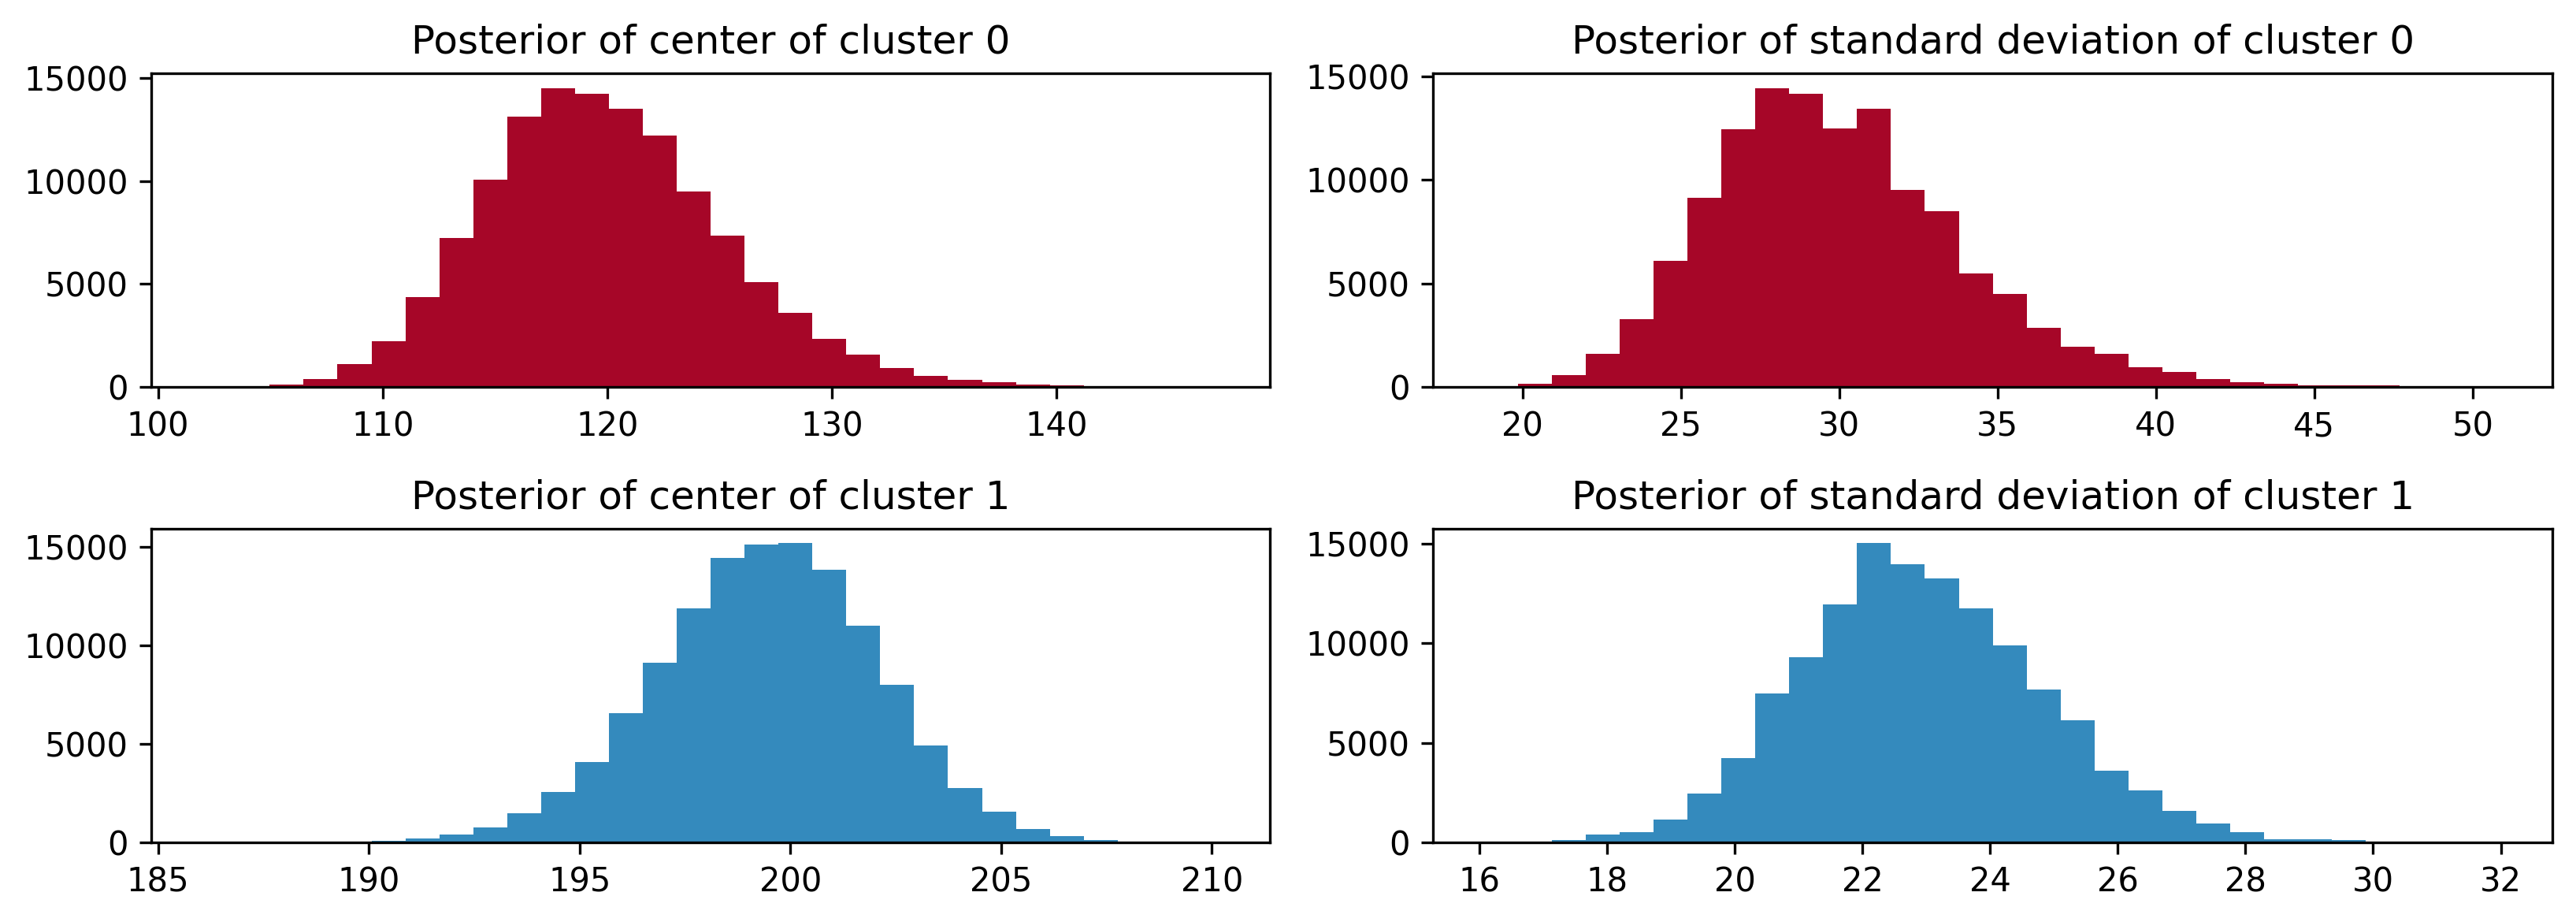

In [55]:
figsize(11, 4)
std_trace = trace['sds'][25000:]
prev_std_trace = trace['sds'][:25000]

_i = [1,2,3,4]
for i in range(2):
    plt.subplot(2,2, _i[2*i])
    plt.title('Posterior of center of cluster {}'.format(i))
    plt.hist(center_trace[:,i], color=colors[i], bins=30, histtype='stepfilled')
    plt.subplot(2,2, _i[2*i+1])
    plt.title('Posterior of standard deviation of cluster {}'.format(i))
    plt.hist(std_trace[:,i], color=colors[i], bins=30, histtype='stepfilled')

plt.tight_layout()

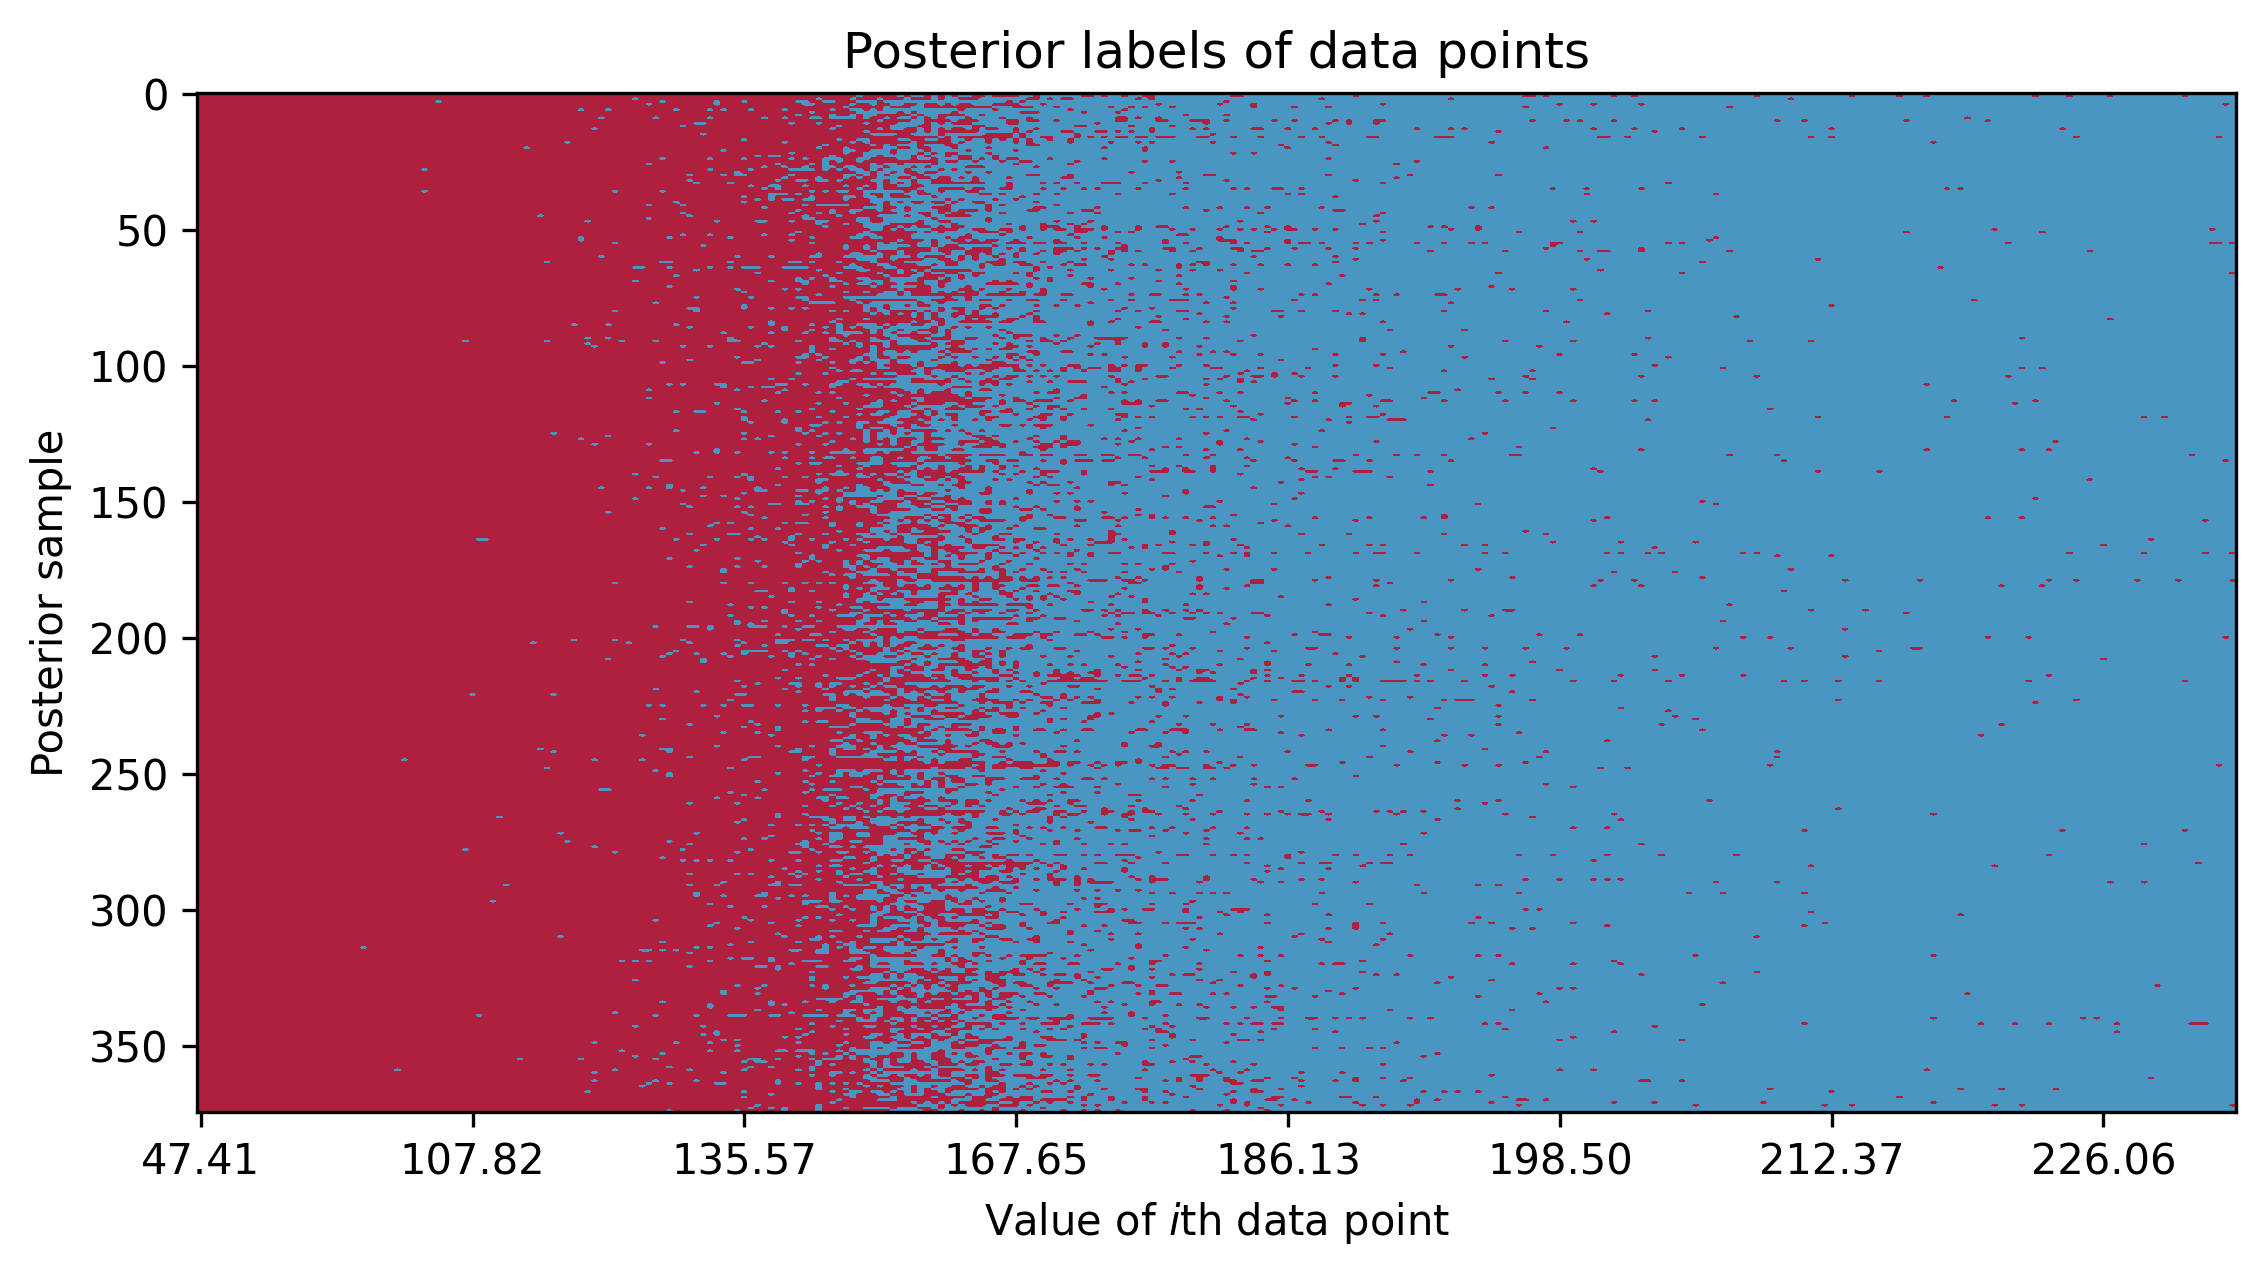

In [56]:
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace['assignment'][::400, np.argsort(data)],
           cmap=plt.cmap,
           aspect=0.4,
           alpha=0.9)
plt.xticks(np.arange(0, data.shape[0], 40),
           ['{:.2f}'.format(s) for s in np.sort(data)[::40]])
plt.ylabel('Posterior sample')
plt.xlabel('Value of $i$th data point')
plt.title('Posterior labels of data points');

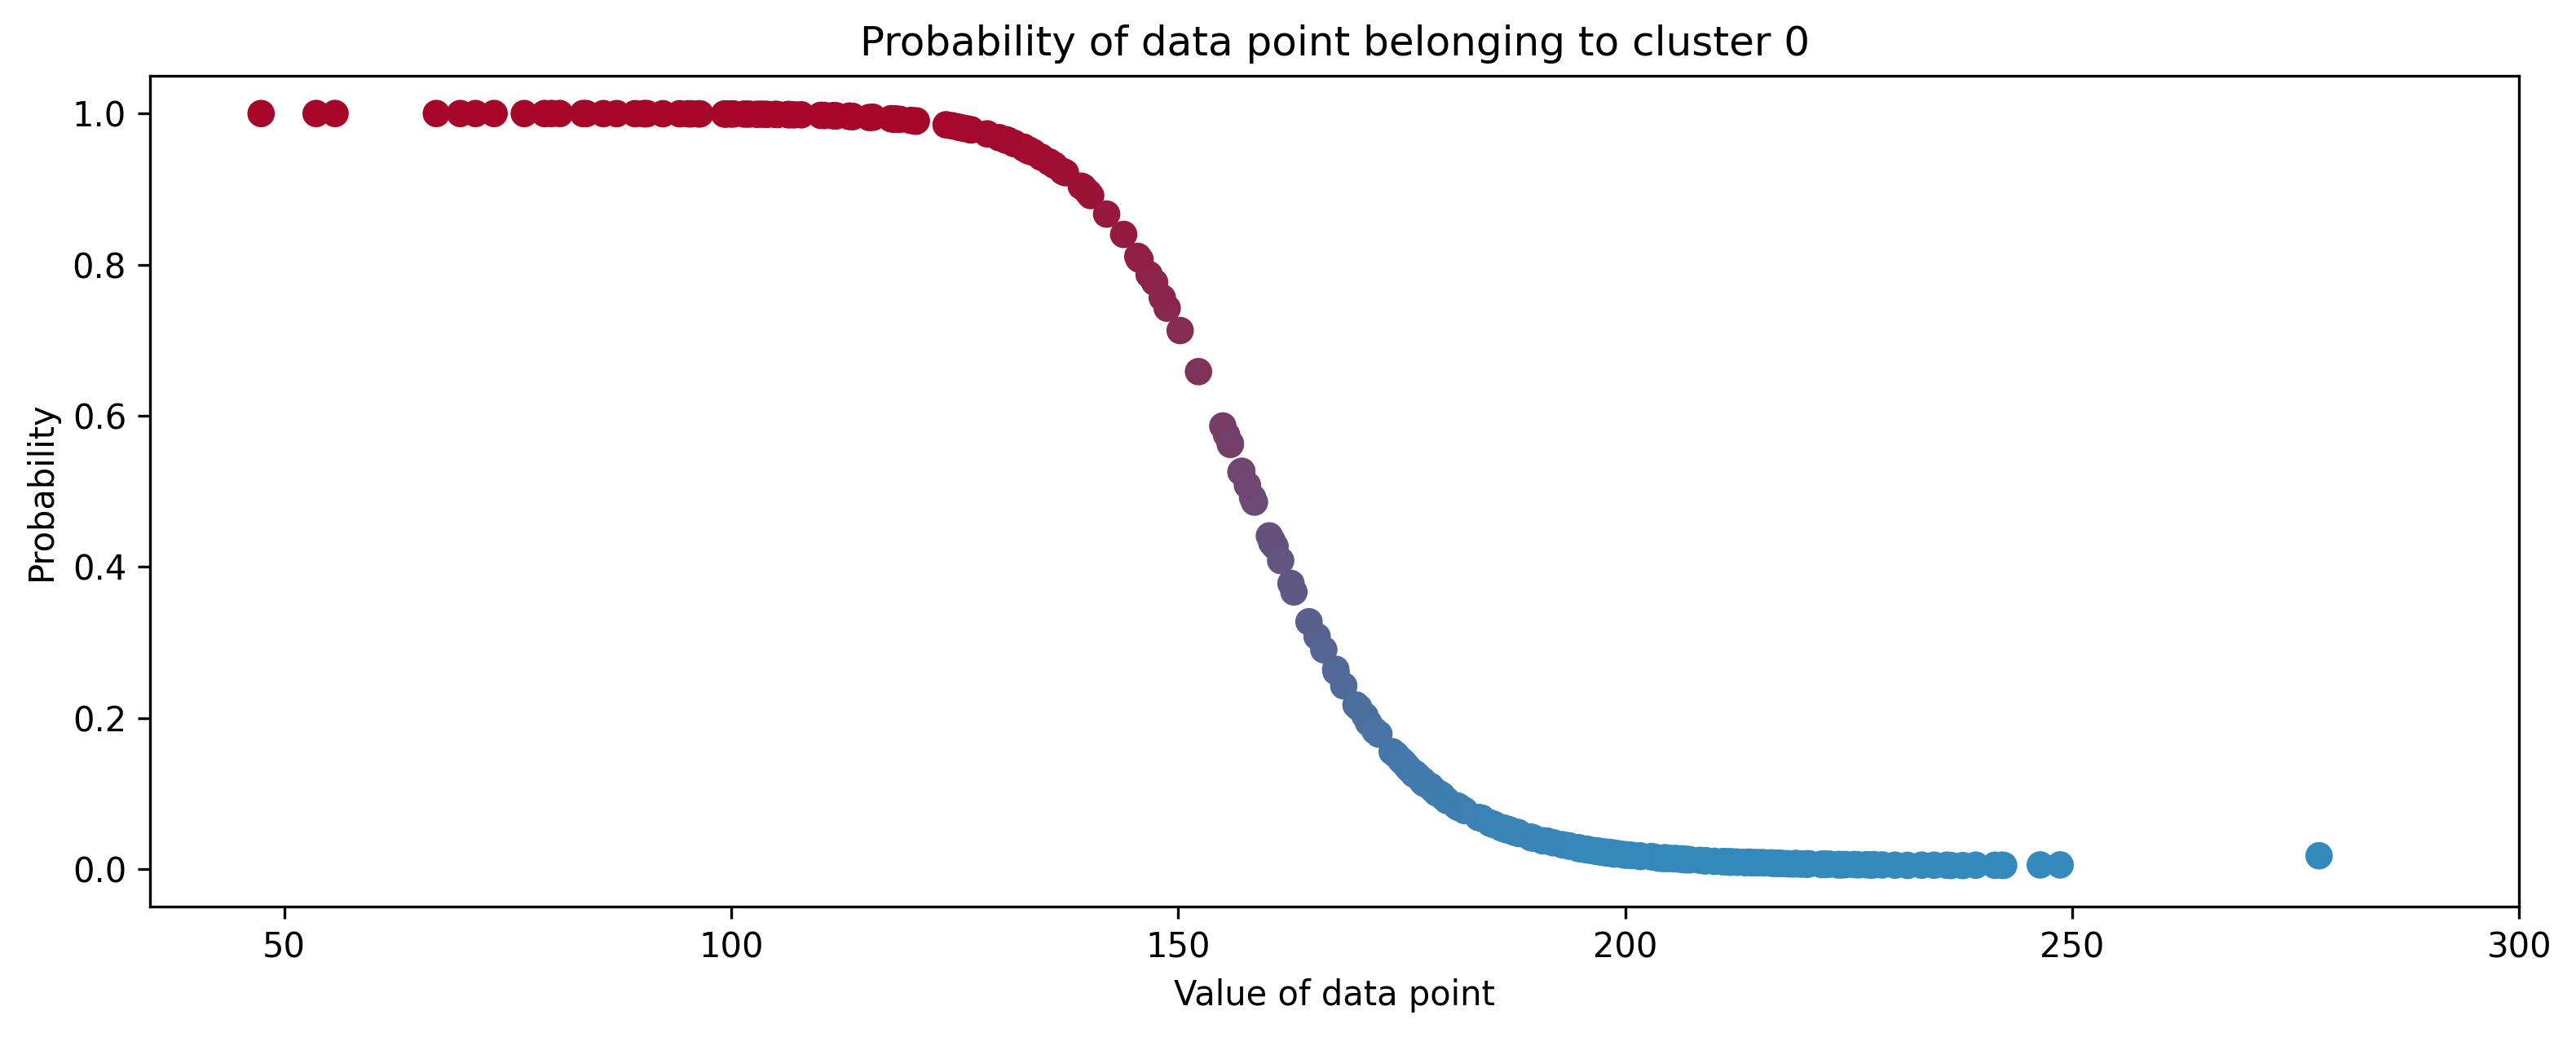

In [57]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('BMH', colors)
assign_trace = trace['assignment']
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
            c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title('Probability of data point belonging to cluster 0')
plt.ylabel('Probability')
plt.xlabel('Value of data point');

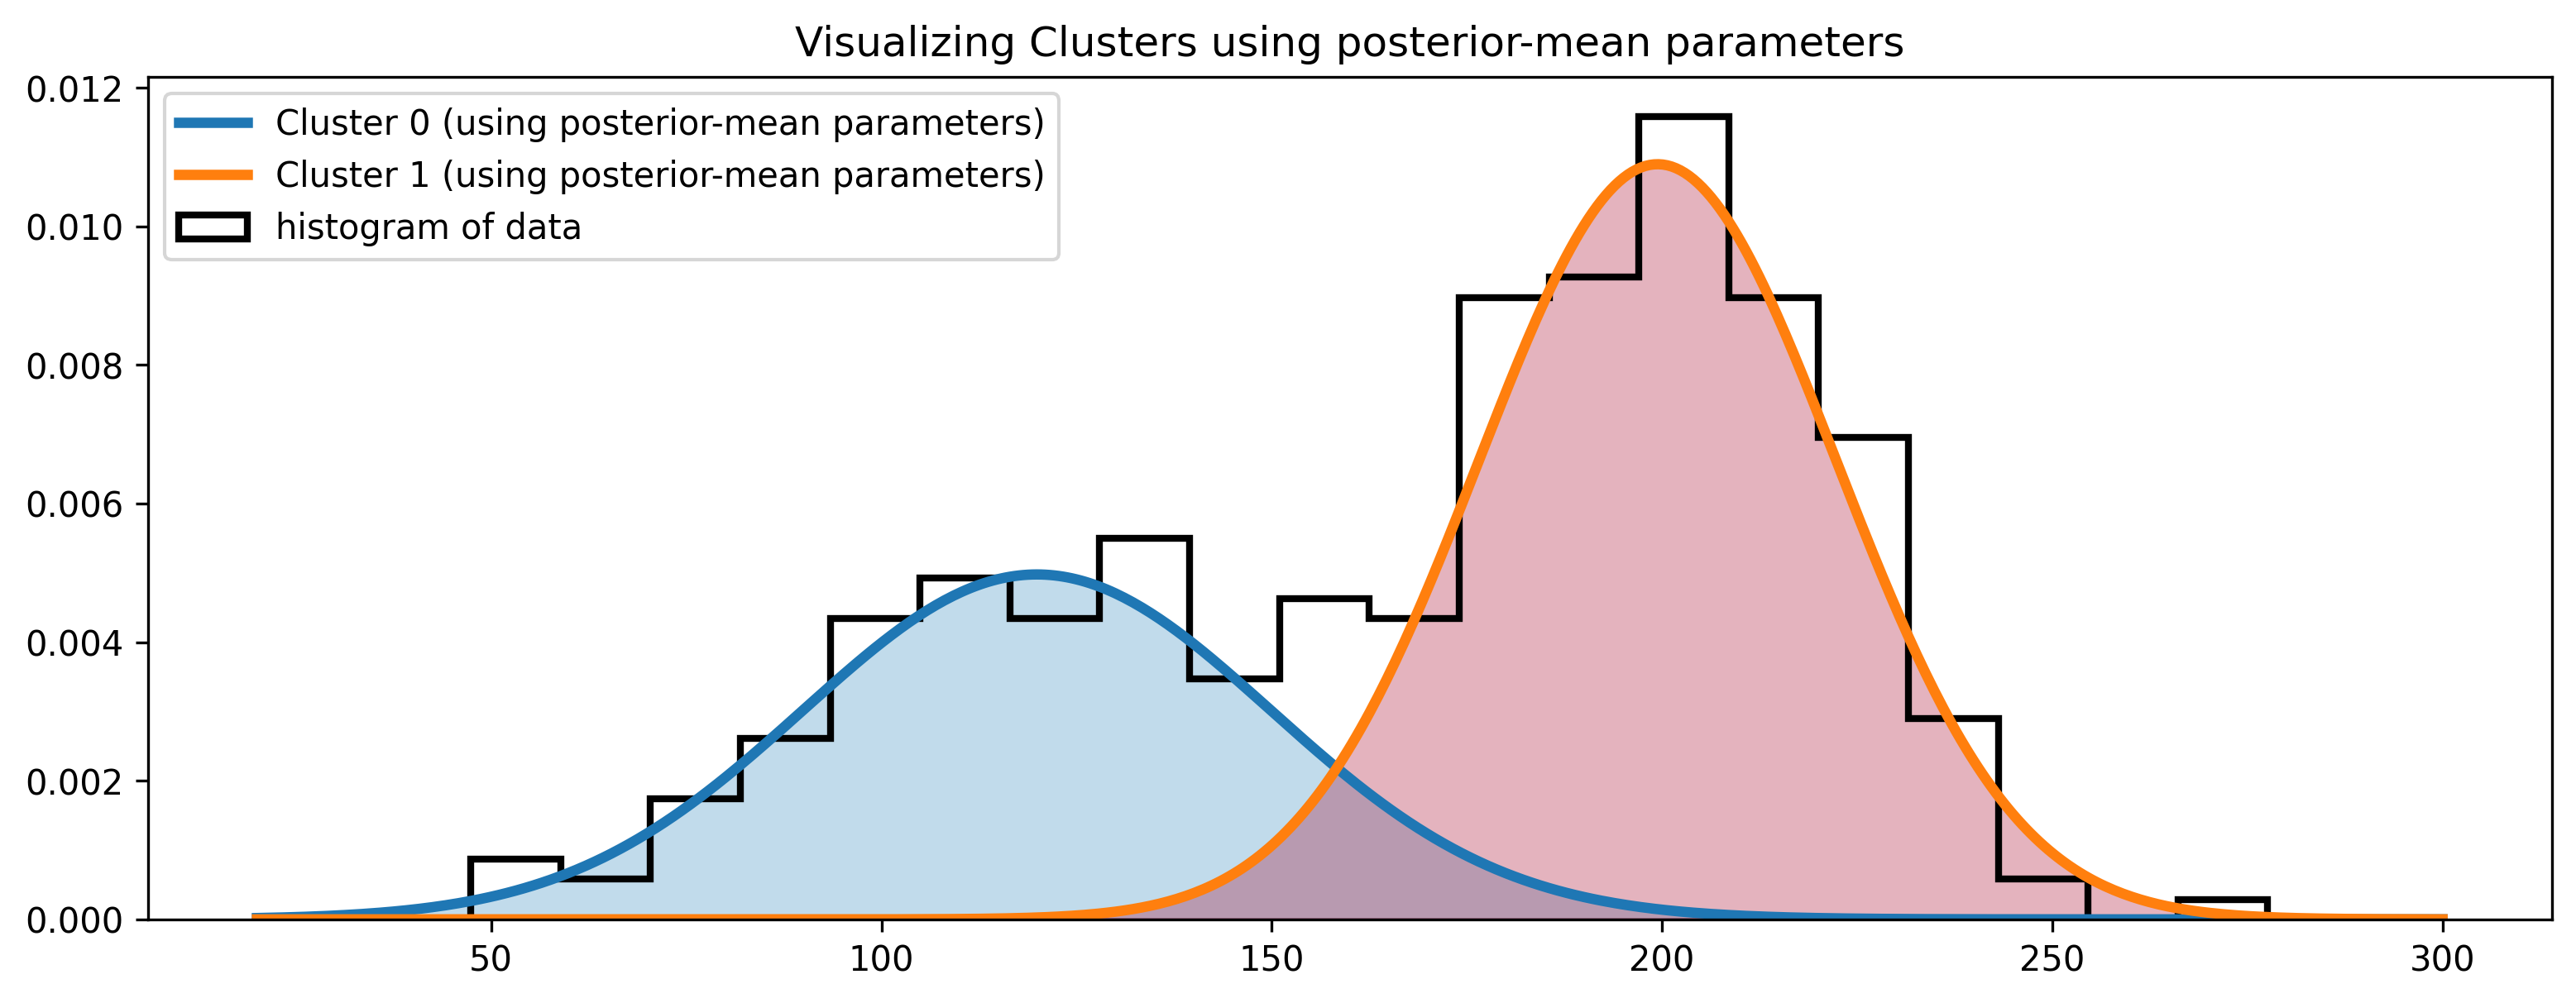

In [59]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace['p'].mean()

plt.hist(data, bins=20, histtype='step', density=True, color='k', 
         lw=2, label='histogram of data')

y = posterior_p_mean * norm.pdf(x, 
                                loc=posterior_center_means[0],
                                scale=posterior_std_means[0])

plt.plot(x, y, label='Cluster 0 (using posterior-mean parameters)', lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, 
                                      loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label='Cluster 1 (using posterior-mean parameters)', lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc='upper left')
plt.title('Visualizing Clusters using posterior-mean parameters');

MAP method in PyMC3 is `find_MAP` function. If this is called within the context of `Model()`, it will calculate the MAP which can be then passed to `pm.sample()` as a `start` parameter:

In [ ]:
with model:
    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

PyMC3 cannot allow user to automatically discard samples with a `burn` parameter, but it is easy to simply discard the beginning section of the trace just through array slicing.

In [ ]:
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(100000, step=step, start=start)

burned_trace = trace[50000:]

Autocorrelation:

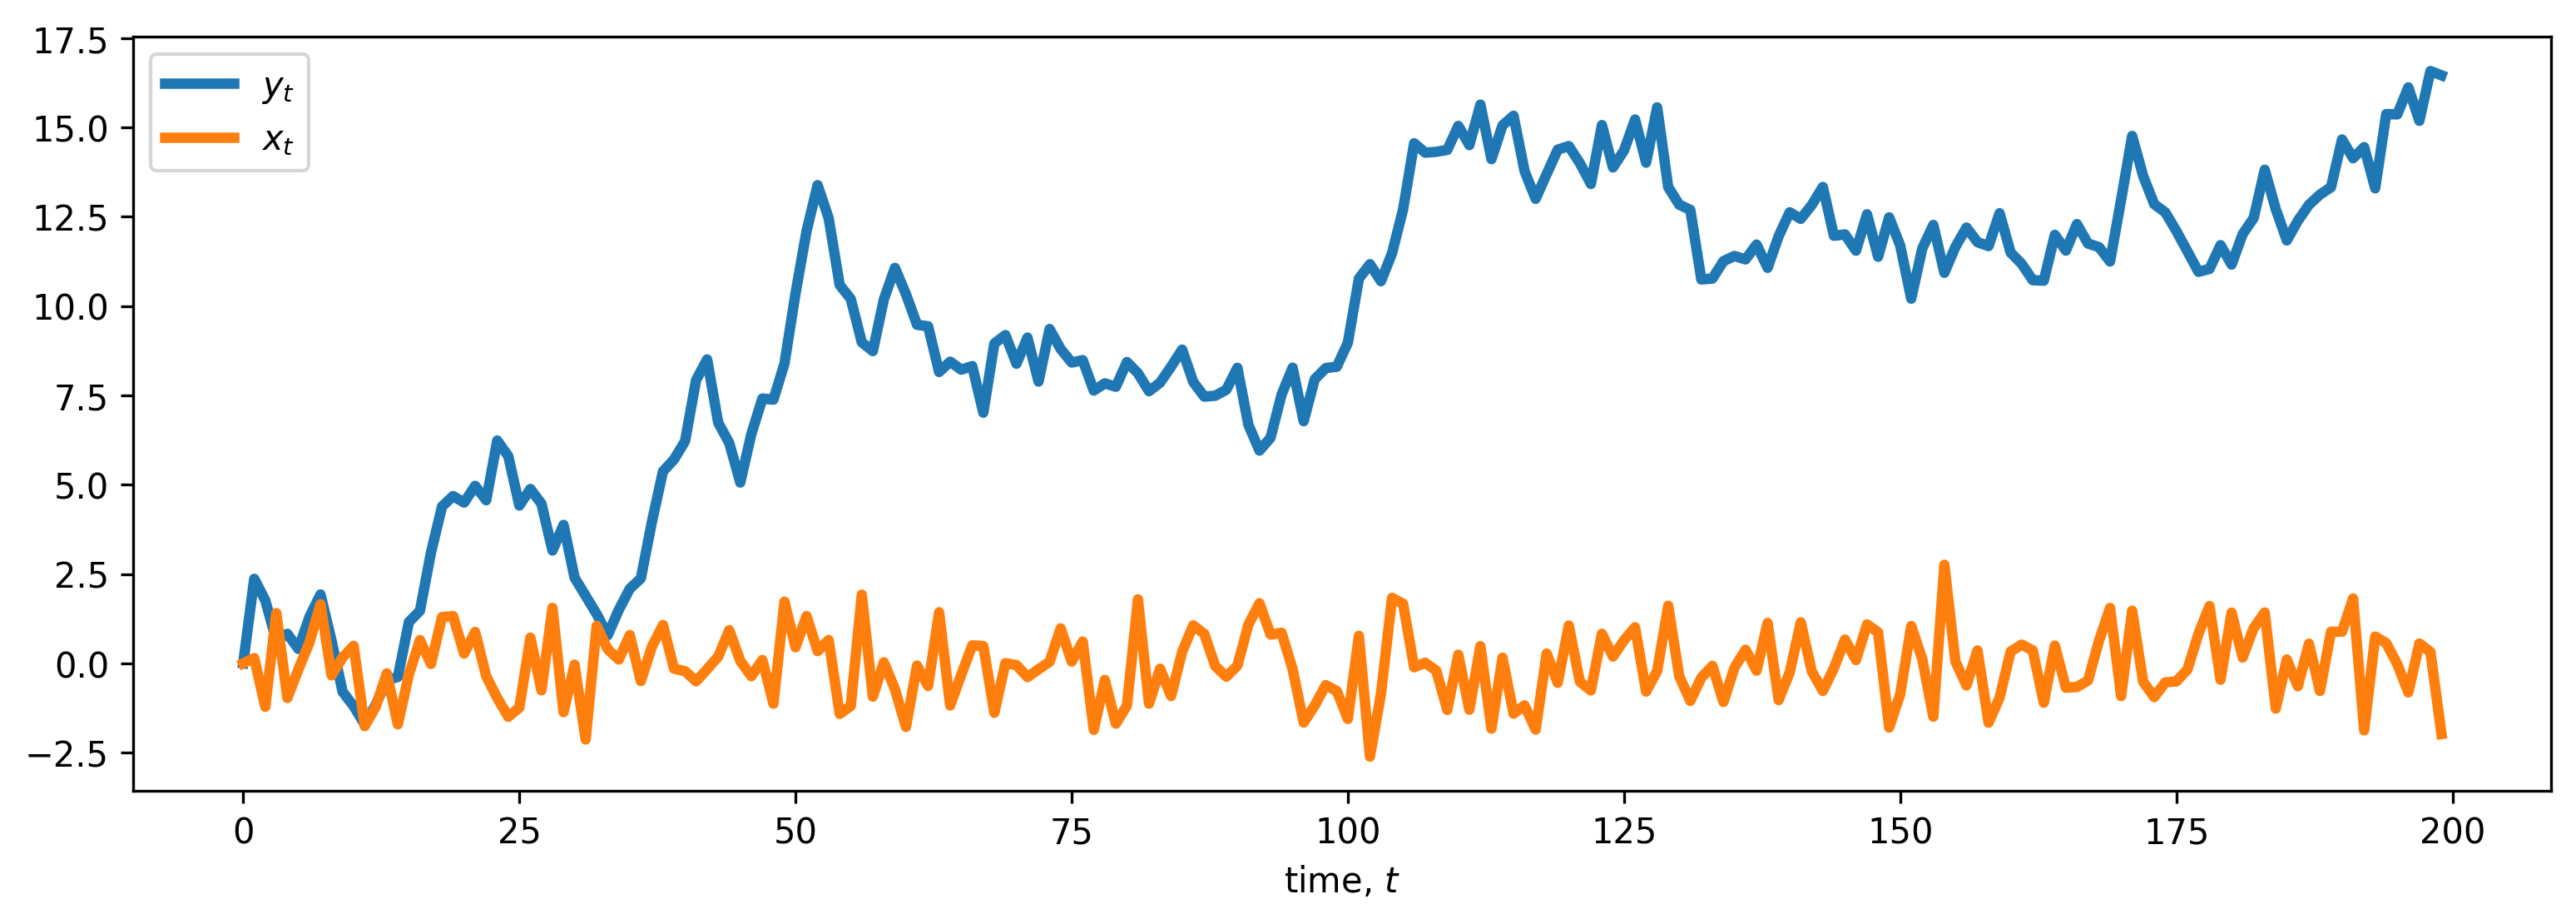

In [60]:
figsize(12.5, 4)
plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();

`pymc3.plots`



In [ ]:
!pip install arviz

In [ ]:
import arviz
pm.plots.traceplot(trace=trace, varnames=["centers"])
pm.plots.plot_posterior(trace=trace["centers"][:,0])
pm.plots.plot_posterior(trace=trace["centers"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["centers"]);